In [400]:
# Introduction

# This notebook aims to predict ICU mortality using the GOSSIS dataset.
# The goal is to build a machine learning model that generalizes across diverse healthcare settings,
# providing clinicians with actionable insights to improve patient care globally.




In [401]:


# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import random
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')


# Load the dataset
data = pd.read_csv('dataset.csv')

# Drop unnecessary columns
cols_to_drop = ['encounter_id', 'patient_id', 'hospital_id', 'icu_id', 'Unnamed: 83', 'gcs_unable_apache']
data.drop(columns=cols_to_drop, inplace=True)

# Save 'apache_4a_hospital_death_prob' and 'apache_4a_icu_death_prob' in a separate DataFrame
apache_probs = data[['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']].copy()

# Drop these columns from the main dataset
data.drop(columns=['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob'], inplace=True)

# Replace the lowercase value with the uppercase value to combine these categories
data['apache_2_bodysystem'] = data['apache_2_bodysystem'].replace('Undefined diagnoses', 'Undefined Diagnoses')

# Convert binary variables to categorical
binary_categorical_vars = [
    'intubated_apache', 'ventilated_apache', 'aids', 'cirrhosis',
    'diabetes_mellitus', 'hepatic_failure', 'immunosuppression',
    'leukemia', 'lymphoma', 'solid_tumor_with_metastasis',
    'apache_post_operative', 'arf_apache', 'elective_surgery'
]
for col in binary_categorical_vars:
    data[col] = data[col].astype('category')

# Convert target variable to integer if it's not already
data['hospital_death'] = data['hospital_death'].astype(int)




In [402]:
# Set display options to show all rows for missing values
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns (if needed)

# Calculate and display missing values in each column
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0]

print("Missing Values in Each Column:")
print(missing_values)

# Reset display options back to default if needed
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

Missing Values in Each Column:
age                            4228
bmi                            3429
ethnicity                      1395
gender                           25
height                         1334
icu_admit_source                112
weight                         2720
apache_2_diagnosis             1662
apache_3j_diagnosis            1101
arf_apache                      715
gcs_eyes_apache                1901
gcs_motor_apache               1901
gcs_verbal_apache              1901
heart_rate_apache               878
intubated_apache                715
map_apache                      994
resprate_apache                1234
temp_apache                    4108
ventilated_apache               715
d1_diasbp_max                   165
d1_diasbp_min                   165
d1_diasbp_noninvasive_max      1040
d1_diasbp_noninvasive_min      1040
d1_heartrate_max                145
d1_heartrate_min                145
d1_mbp_max                      220
d1_mbp_min                      2

In [403]:
# Handling Missing Values

# Calculate the value counts for 'hospital_death' and convert them to percentages
hospital_death_counts = data['hospital_death'].value_counts(normalize=True) * 100

# Display the percentage distribution of hospital deaths
print("Percentage Distribution of Hospital Deaths:")
print(hospital_death_counts)

# For now, drop any rows that have missing values
data = data.dropna()

# Alternative strategies:
# - Impute numerical features using mean, median, or mode
# - Use KNN imputation or regression models to estimate missing values
# - Impute categorical features with the most frequent category or 'Unknown'
# - Use advanced imputation techniques like MICE (Multiple Imputation by Chained Equations)



Percentage Distribution of Hospital Deaths:
0    91.369817
1     8.630183
Name: hospital_death, dtype: float64


In [404]:
# Recalculate numerical and categorical features after dropping missing values
categorical_features = data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
if 'hospital_death' in numerical_features:
    numerical_features.remove('hospital_death')

# Calculate the value counts for 'hospital_death' and convert them to percentages
hospital_death_counts = data['hospital_death'].value_counts(normalize=True) * 100
print("Percentage Distribution of Hospital Deaths:")
print(hospital_death_counts)

Percentage Distribution of Hospital Deaths:
0    91.584214
1     8.415786
Name: hospital_death, dtype: float64


In [405]:
# Handle comorbidity variables
comorbidity_vars = [
    'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
    'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis'
]
# Convert comorbidity variables to integers
data[comorbidity_vars] = data[comorbidity_vars].astype(int)
# Compute comorbidity count
data['comorbidity_count'] = data[comorbidity_vars].sum(axis=1)

# Handle GCS variables
gcs_vars = ['gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache']
# Convert GCS variables to numeric (if not already)
data[gcs_vars] = data[gcs_vars].apply(pd.to_numeric)
# Compute GCS total
data['gcs_total'] = data[gcs_vars].sum(axis=1)

# Re-express categorical variables
# Ethnicity
ethnicities_to_combine = ['Asian', 'Native American', 'Other/Unknown']
data['ethnicity'] = data['ethnicity'].apply(lambda x: x if x not in ethnicities_to_combine else 'Other')

# ICU Admit Source
icu_admit_sources_to_combine = ['Other ICU']
data['icu_admit_source'] = data['icu_admit_source'].apply(
    lambda x: x if x not in icu_admit_sources_to_combine else 'Other'
)

# ICU Type
icu_types_to_combine = ['SICU', 'CTICU', 'CSICU']
data['icu_type'] = data['icu_type'].apply(
    lambda x: x if x not in icu_types_to_combine else 'Other'
)

# APACHE 3J Bodysystem
apache_3j_bodysystem_to_combine = [
    'Gynecological',
    'Musculoskeletal/Skin',
    'Hematological',
    'Genitourinary',
    'Trauma',
    'Metabolic'
]
data['apache_3j_bodysystem'] = data['apache_3j_bodysystem'].apply(
    lambda x: x if x not in apache_3j_bodysystem_to_combine else 'Other'
)

In [406]:
# --- One-Hot Encode Categorical Variables ---


categorical_vars = [
    'ethnicity', 'icu_admit_source', 'icu_type', 'apache_3j_bodysystem',
    'gender', 'apache_2_bodysystem', 'icu_stay_type'
]
data = pd.get_dummies(data, columns=categorical_vars, drop_first=True)

### PCA Exploration

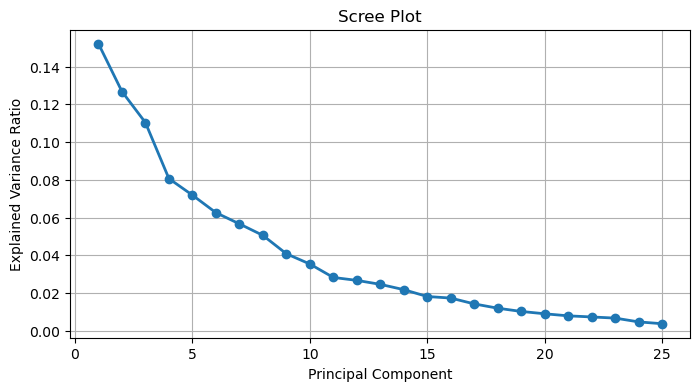

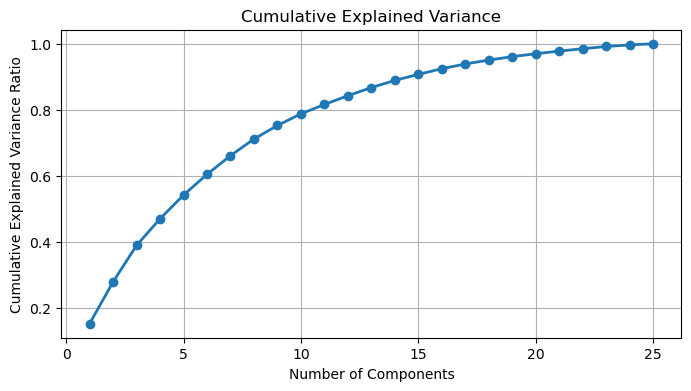

PCA Components for Physiological Data:


heart_rate_apache  d1_heartrate_max  d1_heartrate_min  map_apache  \
0           -0.079655         -0.122998         -0.006241    0.301547   
1            0.275676          0.316439          0.120526    0.230832   
2            0.374275          0.327130          0.395566   -0.093646   
3           -0.004376          0.072342         -0.126246    0.047245   
4            0.125526          0.074767          0.172464    0.015667   
5           -0.056211         -0.075178          0.025626    0.022677   
6           -0.275220         -0.251578         -0.246779    0.001016   
7           -0.215500         -0.187090         -0.192102   -0.034830   
8            0.022726          0.014283          0.006960    0.012915   
9            0.053830          0.093708         -0.112037   -0.005317   
10           0.072884          0.074724         -0.001470   -0.023762   
11          -0.072152         -0.056942          0.033518    0.044476   
12           0.001198         -0.029291          0.119900   -0.128607   
13           0.024010         -0.053560          0.010395    0.892268   
14           0.223208          0.214201         -0.199761    0.050140   
15           0.267429          0.324247         -0.773592   -0.038114   
16          -0.051924          0.105685         -0.084126    0.120295   
17          -0.015126          0.001879          0.041256    0.033966   
18          -0.058606          0.008038          0.035335   -0.038213   
19          -0.109147          0.053269          0.057885   -0.011639   
20          -0.030597          0.041389          0.007784    0.007971   
21           0.012855         -0.018096          0.000329   -0.008224   
22          -0.693380          0.686452          0.068511    0.039483   
23           0.019737         -0.053006         -0.003997    0.066978   
24          -0.008021          0.016023         -0.010590   -0.005224   

    d1_mbp_max  d1_mbp_min  d1_sysbp_max  d1_sysbp_min  d1_diasbp_max  \
0     0.281549    0.418195      0.270112      0.408382       0.208242   
1     0.345287    0.005899      0.283700     -0.029754       0.331455   
2    -0.128840    0.004523     -0.157364     -0.027494      -0.110921   
3     0.253459   -0.269349      0.206547     -0.219718       0.279134   
4    -0.112816    0.147460     -0.123692      0.085805      -0.159189   
5    -0.031563    0.070317      0.044288      0.114827      -0.033923   
6    -0.011485    0.028648     -0.005166      0.002188      -0.108168   
7    -0.006821   -0.083733      0.088899     -0.012121      -0.059310   
8     0.035575   -0.058573      0.001055     -0.039035       0.088857   
9    -0.154364    0.247301     -0.121211      0.135267      -0.209540   
10    0.054876   -0.046611     -0.053427     -0.128380       0.044797   
11    0.001503   -0.008315      0.088117      0.040388      -0.070972   
12    0.054365   -0.001788     -0.027307     -0.031415       0.069451   
13   -0.121076   -0.103385     -0.238000     -0.183609      -0.185147   
14   -0.171129   -0.059941      0.551332      0.385821      -0.449058   
15    0.001414    0.084670     -0.207970     -0.129597       0.087099   
16   -0.095068   -0.006363     -0.059082      0.015332       0.023274   
17    0.002394   -0.015325     -0.012422      0.032509      -0.006592   
18    0.006431    0.002165      0.053398     -0.004244      -0.015786   
19    0.001182    0.064754      0.484581     -0.645182      -0.353596   
20    0.002341   -0.006693     -0.046702      0.077725       0.016505   
21    0.021540   -0.003831     -0.032937      0.035340       0.010086   
22   -0.058678    0.006042     -0.057393      0.092727       0.033908   
23   -0.698639   -0.349150      0.254614      0.088540       0.451290   
24    0.361467   -0.709386     -0.106370      0.288139      -0.276775   

    d1_diasbp_min  ...  d1_temp_min  d1_spo2_max  d1_spo2_min  d1_glucose_max  \
0        0.379735  ...     0.130622    -0.106424     0.124544       -0.043739   
1        0.014245  ...    -0.095397     0.08

In [407]:
# List of physiological variables
physiological_vars = [
    'heart_rate_apache', 'd1_heartrate_max', 'd1_heartrate_min',
    'map_apache', 'd1_mbp_max', 'd1_mbp_min',
    'd1_sysbp_max', 'd1_sysbp_min',
    'd1_diasbp_max', 'd1_diasbp_min',
    'resprate_apache', 'd1_resprate_max', 'd1_resprate_min',
    'temp_apache', 'd1_temp_max', 'd1_temp_min',
    'd1_spo2_max', 'd1_spo2_min',
    'd1_glucose_max', 'd1_glucose_min',
    'd1_potassium_max', 'd1_potassium_min',
    'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache'
]

# Ensure all variables are in the dataset
physiological_vars = [var for var in physiological_vars if var in data.columns]

# Extract the physiological data
physio_data = data[physiological_vars]
physio_data = physio_data.dropna()



# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
physio_data_scaled = scaler.fit_transform(physio_data)


# Initialize PCA
pca = PCA()

# Fit PCA on the scaled data
pca.fit(physio_data_scaled)

# Transform the data
physio_pca = pca.transform(physio_data_scaled)

# Calculate explained variance ratios
explained_variance = pca.explained_variance_ratio_

# Generate scree plot
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'o-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Plot cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, 'o-', linewidth=2)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

# Get PCA components for physiological data
physio_components = pd.DataFrame(pca.components_, columns=physio_data.columns)
print("PCA Components for Physiological Data:")
display(physio_components)

Data retained after dropping missing values: 100.00%


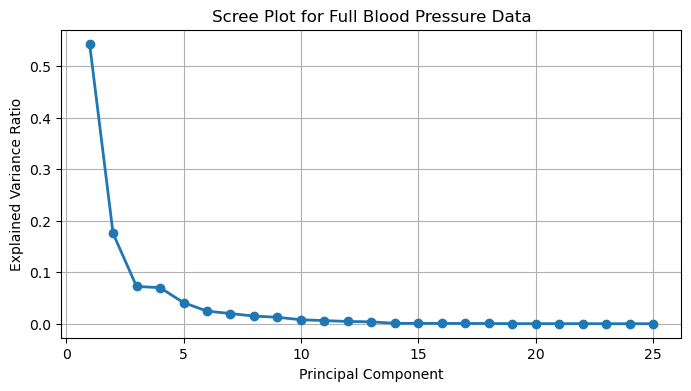

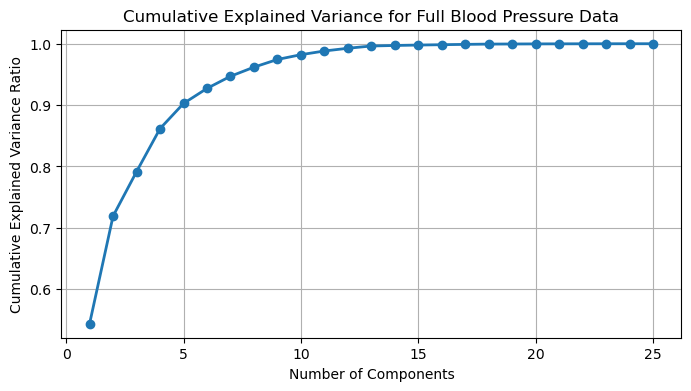

PCA Components for Full Blood Pressure Data:


map_apache  d1_mbp_max  d1_mbp_min  d1_mbp_noninvasive_max  \
0     0.161973    0.191893    0.186344                0.191838   
1     0.050544    0.256807   -0.283366                0.256122   
2    -0.126929   -0.100814   -0.094219               -0.101880   
3    -0.197137   -0.233208   -0.210562               -0.233289   
4    -0.044247   -0.124238    0.131242               -0.125049   
5     0.869805    0.015583    0.005692                0.015459   
6     0.287050   -0.056352   -0.084088               -0.057308   
7    -0.272644    0.353088    0.177696                0.356768   
8    -0.019496   -0.025829   -0.025273               -0.023902   
9    -0.017564    0.269260   -0.444745                0.266380   
10   -0.002844   -0.066281    0.029186               -0.071697   
11   -0.014939    0.178730    0.283482                0.184724   
12    0.007445   -0.276745    0.018775               -0.280365   
13   -0.000349   -0.032194   -0.008012                0.039596   
14    0.001074   -0.186166    0.022796                0.189127   
15   -0.001074    0.653821   -0.065515               -0.648374   
16    0.002445    0.126722   -0.011146               -0.128311   
17    0.000945    0.020309    0.015421               -0.022271   
18   -0.000375    0.076868    0.515251               -0.073180   
19   -0.000301   -0.046497   -0.009645                0.045799   
20    0.000034    0.005200    0.007122               -0.009383   
21   -0.000857    0.113103   -0.102589               -0.110898   
22    0.000005    0.048076    0.462965               -0.047022   
23   -0.000046   -0.014514    0.008688                0.014797   
24   -0.000219   -0.000964   -0.007552                0.000894   

    d1_mbp_noninvasive_min  h1_mbp_max  h1_mbp_min  h1_mbp_noninvasive_max  \
0                 0.186451    0.232531    0.234665                0.232755   
1                -0.284009    0.109044   -0.116749                0.107984   
2                -0.093956    0.169258    0.136025                0.169394   
3                -0.210398    0.099394    0.136395                0.098257   
4                 0.130670    0.271130   -0.254122                0.270988   
5                 0.005020    0.105681    0.082909                0.103124   
6                -0.082817   -0.007264   -0.071009               -0.010549   
7                 0.176037    0.291664    0.214643                0.291735   
8                -0.023629    0.024577    0.055560                0.024315   
9                -0.436330    0.135108   -0.195255                0.132101   
10                0.029183    0.078490   -0.045959                0.079519   
11                0.283347   -0.056201   -0.447859               -0.050578   
12                0.017293    0.442288   -0.172310                0.448858   
13                0.002802   -0.230112   -0.129483                0.219218   
14               -0.025108   -0.283312    0.008690                0.282574   
15                0.071016   -0.008120   -0.004695                0.003529   
16                0.008888   -0.396707   -0.099734                0.401862   
17               -0.018331   -0.415797    0.030861                0.414368   
18               -0.518230   -0.012802    0.133450                0.010480   
19                0.009394   -0.166687   -0.053042                0.164227   
20               -0.006431    0.086217   -0.651935               -0.084986   
21                0.104154   -0.052197    0.092125                0.049682   
22               -0.467311    0.014945   -0.126628               -0.013994   
23               -0.009187   -0.000451   -0.001253                0.000635   
24                0.007263   -0.006069    0.010519                0.007075   

    h1_mbp_noninvasive_min  d1_sysbp_max  ...  h1_sysbp_noninvasive_max  \
0                 0.234753      0.186923  ...                  0.219277   
1                -0.117288      0.211937  ...                  0.109174   
2                 0.135936     -0

In [408]:
# List of all blood pressure variables, excluding 'mean' columns
bp_vars_full = [
    'map_apache',
    'd1_mbp_max', 'd1_mbp_min',
    'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min',
    'h1_mbp_max', 'h1_mbp_min',
    'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min',
    'd1_sysbp_max', 'd1_sysbp_min',
    'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',
    'h1_sysbp_max', 'h1_sysbp_min',
    'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min',
    'd1_diasbp_max', 'd1_diasbp_min',
    'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min',
    'h1_diasbp_max', 'h1_diasbp_min',
    'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min'
]
# Ensure variables are in the dataset
bp_vars_full = [var for var in bp_vars_full if var in data.columns]
# Extract blood pressure data
bp_data_full = data[bp_vars_full]
# Drop rows with missing values
bp_data_full_clean = bp_data_full.dropna()

# Print the percentage of data retained
data_retained = len(bp_data_full_clean) / len(bp_data_full) * 100
print(f"Data retained after dropping missing values: {data_retained:.2f}%")

scaler = StandardScaler()
bp_data_scaled = scaler.fit_transform(bp_data_full_clean)

pca_bp_full = PCA()
pca_bp_full.fit(bp_data_scaled)
bp_pca_full = pca_bp_full.transform(bp_data_scaled)

explained_variance_bp_full = pca_bp_full.explained_variance_ratio_

# Scree Plot
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance_bp_full) + 1), explained_variance_bp_full, 'o-', linewidth=2)
plt.title('Scree Plot for Full Blood Pressure Data')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Cumulative Explained Variance
cumulative_explained_variance_bp_full = np.cumsum(explained_variance_bp_full)
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_explained_variance_bp_full) + 1), cumulative_explained_variance_bp_full, 'o-', linewidth=2)
plt.title('Cumulative Explained Variance for Full Blood Pressure Data')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()
# PCA Components (Loadings)
bp_components_full = pd.DataFrame(pca_bp_full.components_, columns=bp_data_full_clean.columns)
print("PCA Components for Full Blood Pressure Data:")
display(bp_components_full)


In [409]:
# Blood Pressure Variables to Drop
bp_vars_to_drop = [
    # Non-Invasive Measurements
    'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min',
    'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min',
    'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',
    'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min',
    'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min',
    'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min',
    # Hour 1 Measurements (if choosing to drop)
    'h1_mbp_max', 'h1_mbp_min',
    'h1_sysbp_max', 'h1_sysbp_min',
    'h1_diasbp_max', 'h1_diasbp_min'
]

# Drop the variables from the dataset
data.drop(columns=bp_vars_to_drop, inplace=True)

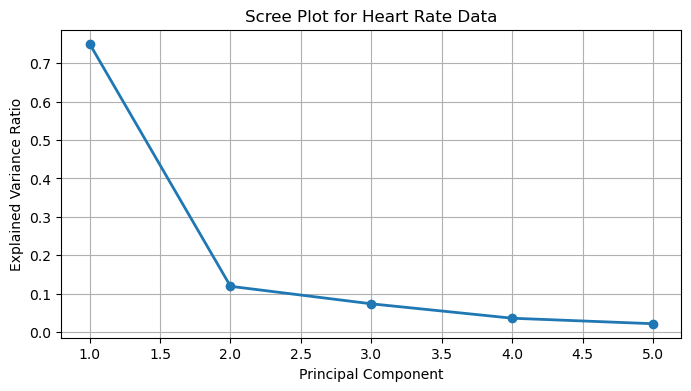

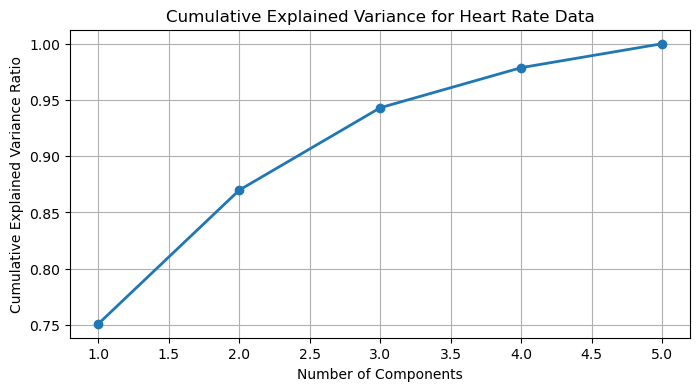

PCA Components for Heart Rate Data:


heart_rate_apache  d1_heartrate_max  d1_heartrate_min  h1_heartrate_max  \
0           0.454720          0.451170          0.385282          0.471476   
1           0.244433          0.470729         -0.809524          0.164421   
2          -0.560031         -0.232314         -0.321200          0.513446   
3          -0.631222          0.633088          0.278104          0.107600   
4          -0.146309          0.346539         -0.125367         -0.689544   

   h1_heartrate_min  
0          0.467914  
1         -0.190533  
2          0.515363  
3         -0.334423  
4          0.606067

In [410]:
# PCA on Heart Rate Variables

# List of heart rate variables
hr_vars = [
    'heart_rate_apache', 'd1_heartrate_max', 'd1_heartrate_min',
    'h1_heartrate_max', 'h1_heartrate_min'
]

# Ensure variables are in the dataset
hr_vars = [var for var in hr_vars if var in data.columns]

# Extract heart rate data
hr_data = data[hr_vars]

# Handle missing values
hr_data = hr_data.dropna()

# Standardize the data
scaler = StandardScaler()
hr_data_scaled = scaler.fit_transform(hr_data)

# Perform PCA

pca_hr = PCA()
pca_hr.fit(hr_data_scaled)
hr_pca = pca_hr.transform(hr_data_scaled)



explained_variance_hr = pca_hr.explained_variance_ratio_
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance_hr) + 1), explained_variance_hr, 'o-', linewidth=2)
plt.title('Scree Plot for Heart Rate Data')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Cumulative explained variance
cumulative_explained_variance_hr = np.cumsum(explained_variance_hr)
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_explained_variance_hr) + 1), cumulative_explained_variance_hr, 'o-', linewidth=2)
plt.title('Cumulative Explained Variance for Heart Rate Data')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

# PCA Components (Loadings)
hr_components = pd.DataFrame(pca_hr.components_, columns=hr_data.columns)
print("PCA Components for Heart Rate Data:")
display(hr_components)


In [411]:
# Heart Rate Variables to Drop
hr_vars_to_drop = ['h1_heartrate_max', 'h1_heartrate_min']

# Drop the variables from the dataset
data.drop(columns=hr_vars_to_drop, inplace=True)

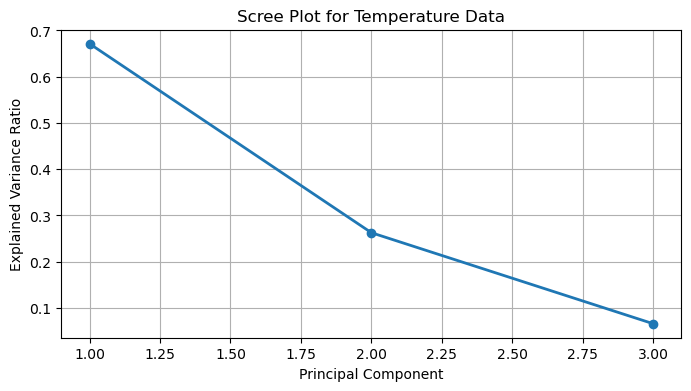

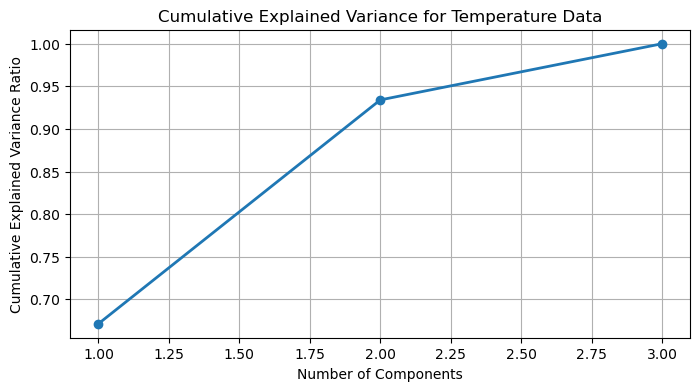

PCA Components for Temperature Data:


temp_apache  d1_temp_max  d1_temp_min
0    -0.656161    -0.430597    -0.619709
1    -0.185002     0.887948    -0.421097
2     0.731592    -0.161660    -0.662298

In [412]:
# PCA on Temperature Variables

# List of temperature variables
temp_vars = [
    'temp_apache', 'd1_temp_max', 'd1_temp_min',
    'h1_temp_max', 'h1_temp_min'
]

# Ensure variables are in the dataset
temp_vars = [var for var in temp_vars if var in data.columns]

# Extract temperature data
temp_data = data[temp_vars]

# Handle missing values
temp_data = temp_data.dropna()

# Standardize the data
scaler = StandardScaler()
temp_data_scaled = scaler.fit_transform(temp_data)

# Perform PCA
pca_temp = PCA()
pca_temp.fit(temp_data_scaled)
temp_pca = pca_temp.transform(temp_data_scaled)

# Generate Scree Plot
explained_variance_temp = pca_temp.explained_variance_ratio_
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance_temp) + 1), explained_variance_temp, 'o-', linewidth=2)
plt.title('Scree Plot for Temperature Data')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Cumulative explained variance
cumulative_explained_variance_temp = np.cumsum(explained_variance_temp)
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_explained_variance_temp) + 1), cumulative_explained_variance_temp, 'o-', linewidth=2)
plt.title('Cumulative Explained Variance for Temperature Data')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

# PCA Components (Loadings)
temp_components = pd.DataFrame(pca_temp.components_, columns=temp_data.columns)
print("PCA Components for Temperature Data:")
display(temp_components)


In [413]:
# Not really much to drop!

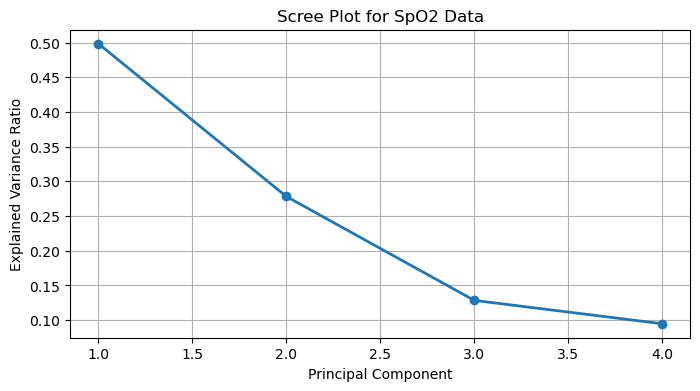

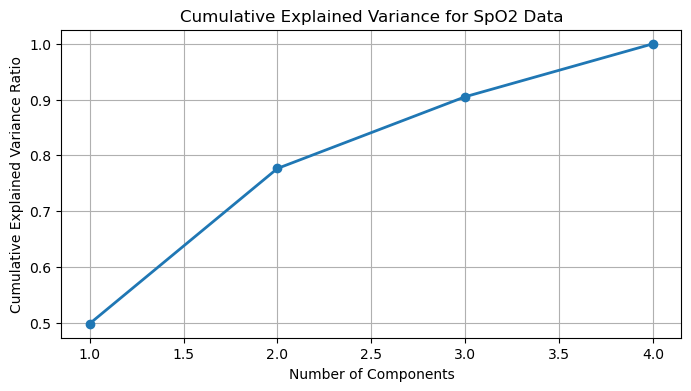

PCA Components for SpO2 Data:


d1_spo2_max  d1_spo2_min  h1_spo2_max  h1_spo2_min
0    -0.400820    -0.454178    -0.551501    -0.573509
1    -0.652951     0.587707    -0.348875     0.326407
2    -0.600268    -0.504389     0.547452     0.292518
3    -0.229514     0.440357     0.523860    -0.692084

In [414]:
# PCA on Peripheral Oxygen Saturation Variables

# List of SpO2 variables
spo2_vars = [
    'd1_spo2_max', 'd1_spo2_min',
    'h1_spo2_max', 'h1_spo2_min'
]

# Ensure variables are in the dataset
spo2_vars = [var for var in spo2_vars if var in data.columns]

# Extract SpO2 data
spo2_data = data[spo2_vars]

# Handle missing values
spo2_data = spo2_data.dropna()

# Standardize the data
scaler = StandardScaler()
spo2_data_scaled = scaler.fit_transform(spo2_data)

# Perform PCA
pca_spo2 = PCA()
pca_spo2.fit(spo2_data_scaled)
spo2_pca = pca_spo2.transform(spo2_data_scaled)

# Generate Scree Plot
explained_variance_spo2 = pca_spo2.explained_variance_ratio_
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance_spo2) + 1), explained_variance_spo2, 'o-', linewidth=2)
plt.title('Scree Plot for SpO2 Data')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Cumulative explained variance
cumulative_explained_variance_spo2 = np.cumsum(explained_variance_spo2)
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_explained_variance_spo2) + 1), cumulative_explained_variance_spo2, 'o-', linewidth=2)
plt.title('Cumulative Explained Variance for SpO2 Data')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

# PCA Components (Loadings)
spo2_components = pd.DataFrame(pca_spo2.components_, columns=spo2_data.columns)
print("PCA Components for SpO2 Data:")
display(spo2_components)


In [415]:
# SpO₂ Variables to Drop
spo2_vars_to_drop = ['h1_spo2_max', 'h1_spo2_min']

# Drop the variables from the dataset
data.drop(columns=spo2_vars_to_drop, inplace=True)

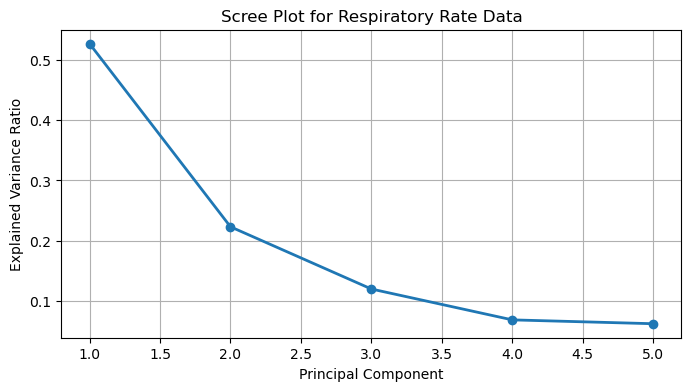

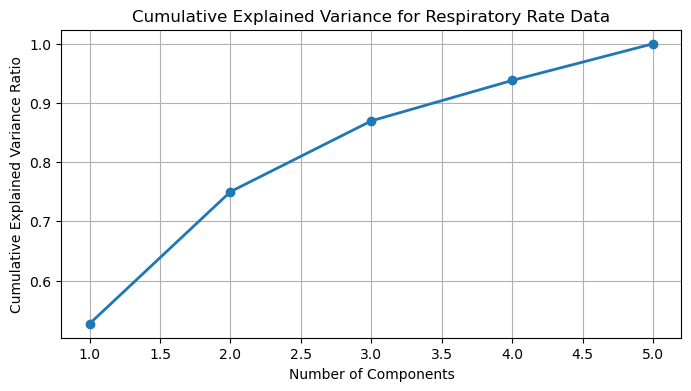

PCA Components for Respiratory Rate Data:


resprate_apache  d1_resprate_max  d1_resprate_min  h1_resprate_max  \
0         0.479149         0.426805         0.341257         0.501368   
1        -0.172408        -0.565489         0.685325        -0.180754   
2        -0.655343        -0.080323        -0.332035         0.522632   
3        -0.516260         0.476194         0.544351         0.129541   
4        -0.211405         0.514633        -0.085484        -0.652713   

   h1_resprate_min  
0         0.469498  
1         0.384910  
2         0.425067  
3        -0.440018  
4         0.507069

In [416]:
# PCA on Respiratory Rate Variables

# List of respiratory rate variables
resp_vars = [
    'resprate_apache', 'd1_resprate_max', 'd1_resprate_min',
    'h1_resprate_max', 'h1_resprate_min'
]

# Ensure variables are in the dataset
resp_vars = [var for var in resp_vars if var in data.columns]

# Extract respiratory rate data
resp_data = data[resp_vars]

# Handle missing values
resp_data = resp_data.dropna()

# Standardize the data
scaler = StandardScaler()
resp_data_scaled = scaler.fit_transform(resp_data)

# Perform PCA
pca_resp = PCA()
pca_resp.fit(resp_data_scaled)
resp_pca = pca_resp.transform(resp_data_scaled)

# Generate Scree Plot
explained_variance_resp = pca_resp.explained_variance_ratio_
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance_resp) + 1), explained_variance_resp, 'o-', linewidth=2)
plt.title('Scree Plot for Respiratory Rate Data')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Cumulative explained variance
cumulative_explained_variance_resp = np.cumsum(explained_variance_resp)
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_explained_variance_resp) + 1), cumulative_explained_variance_resp, 'o-', linewidth=2)
plt.title('Cumulative Explained Variance for Respiratory Rate Data')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

# PCA Components (Loadings)
resp_components = pd.DataFrame(pca_resp.components_, columns=resp_data.columns)
print("PCA Components for Respiratory Rate Data:")
display(resp_components)


In [417]:
# Respiratory Rate Variables to Drop
resp_vars_to_drop = ['h1_resprate_max', 'h1_resprate_min']

# Drop the variables from the dataset
data.drop(columns=resp_vars_to_drop, inplace=True)

### Check variables to make sure they are encoded right

In [418]:

# Exclude the target variable from the features
features = data.drop('hospital_death', axis=1)

# Identify numerical features
numerical_features = features.columns.tolist()

# Identify binary variables (excluding the target variable)
binary_columns = [col for col in features.columns if data[col].nunique() == 2]
print("Binary Columns (0 and 1 values only):")
print(binary_columns)

# Identify continuous numerical features (excluding binary variables)
continuous_numerical_features = [col for col in numerical_features if col not in binary_columns]

# Display lists of features for confirmation
print("Continuous Numerical Features:", continuous_numerical_features)
print("Binary Features:", binary_columns)

Binary Columns (0 and 1 values only):
['elective_surgery', 'apache_post_operative', 'arf_apache', 'intubated_apache', 'ventilated_apache', 'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis', 'ethnicity_Caucasian', 'ethnicity_Hispanic', 'ethnicity_Other', 'icu_admit_source_Floor', 'icu_admit_source_Operating Room / Recovery', 'icu_admit_source_Other', 'icu_admit_source_Other Hospital', 'icu_type_Cardiac ICU', 'icu_type_MICU', 'icu_type_Med-Surg ICU', 'icu_type_Neuro ICU', 'icu_type_Other', 'apache_3j_bodysystem_Gastrointestinal', 'apache_3j_bodysystem_Neurological', 'apache_3j_bodysystem_Other', 'apache_3j_bodysystem_Respiratory', 'apache_3j_bodysystem_Sepsis', 'gender_M', 'apache_2_bodysystem_Gastrointestinal', 'apache_2_bodysystem_Haematologic', 'apache_2_bodysystem_Metabolic', 'apache_2_bodysystem_Neurologic', 'apache_2_bodysystem_Renal/Genitourinary', 'apache_2_bodysystem_Respiratory', 'apache_2_bod

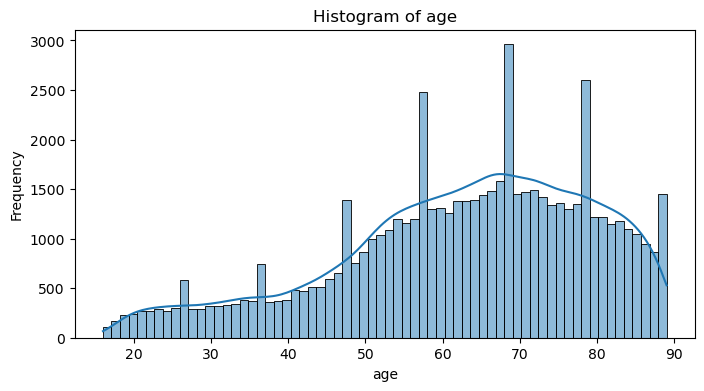

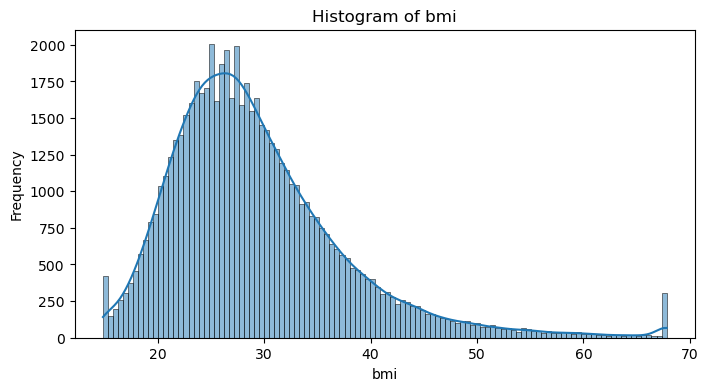

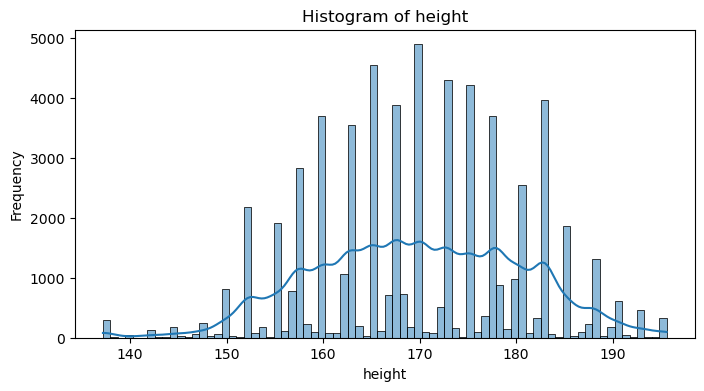

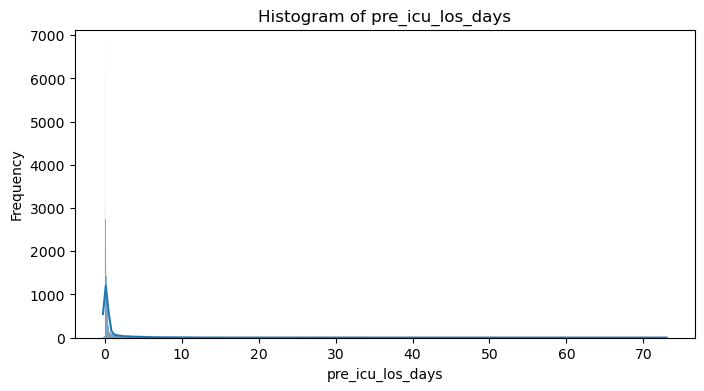

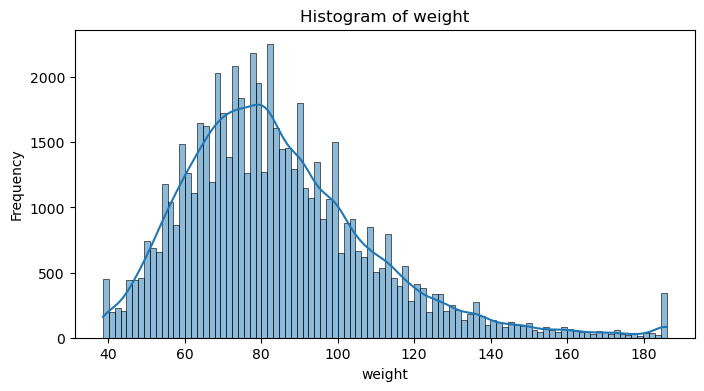

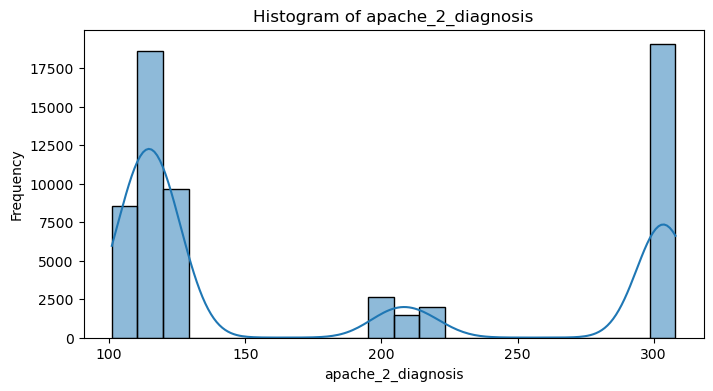

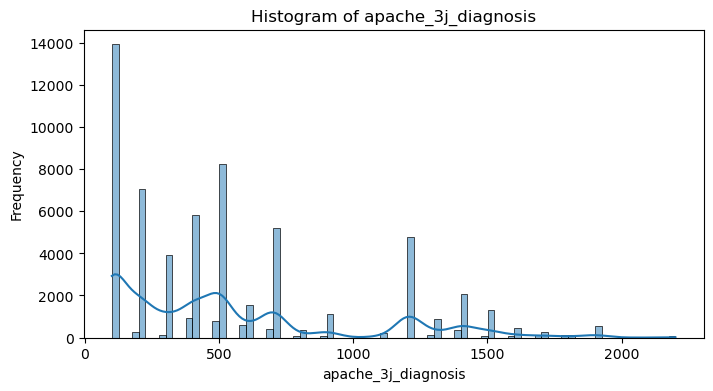

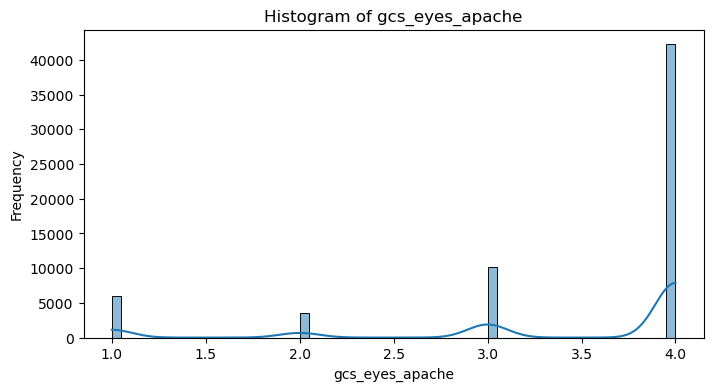

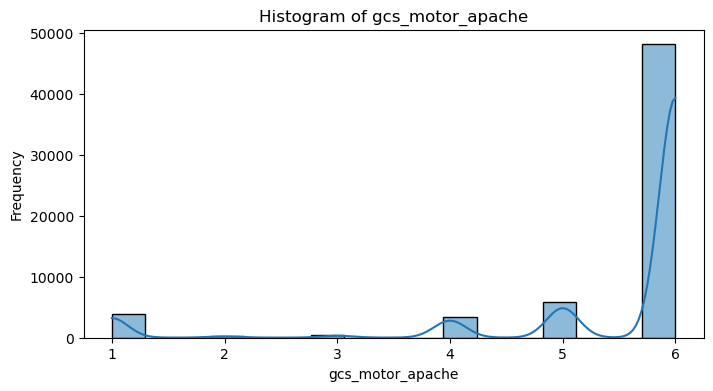

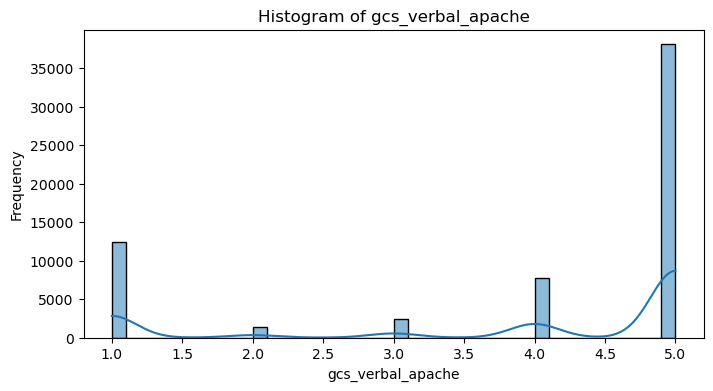

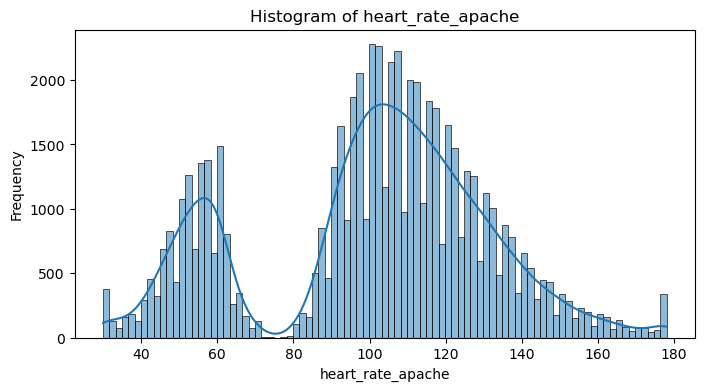

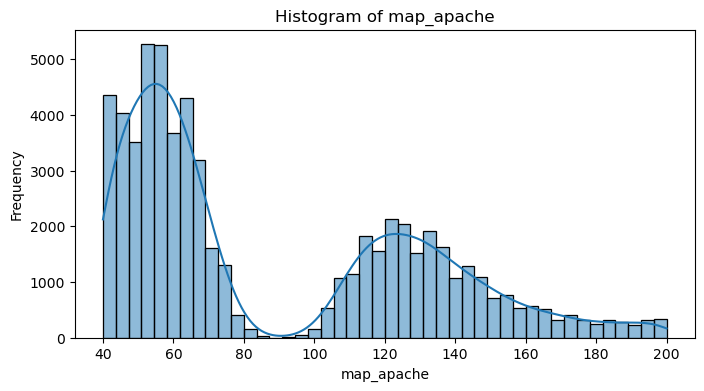

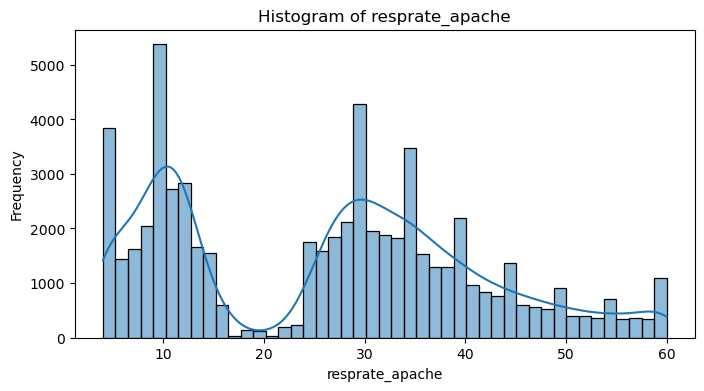

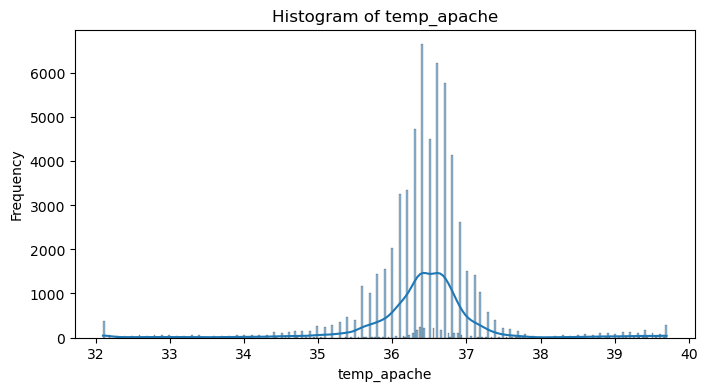

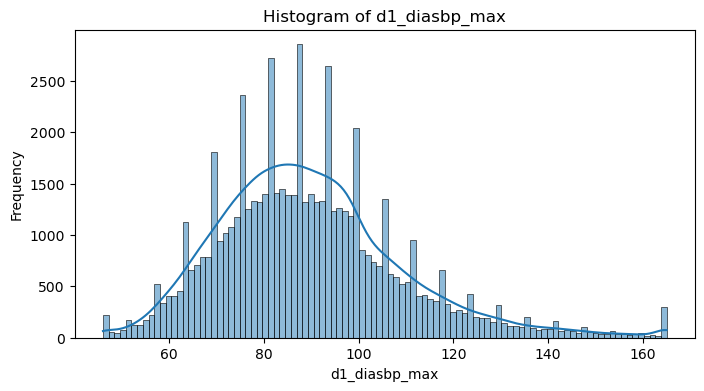

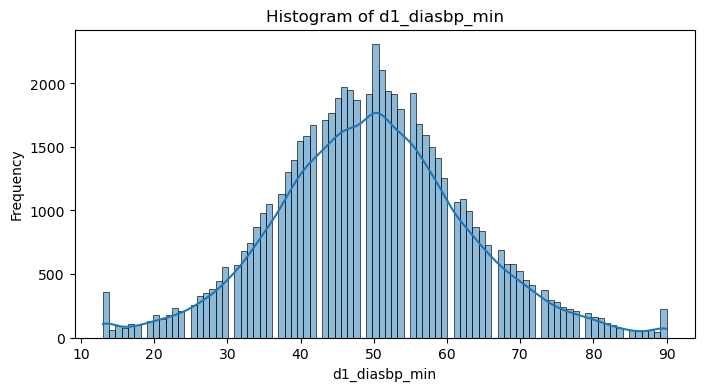

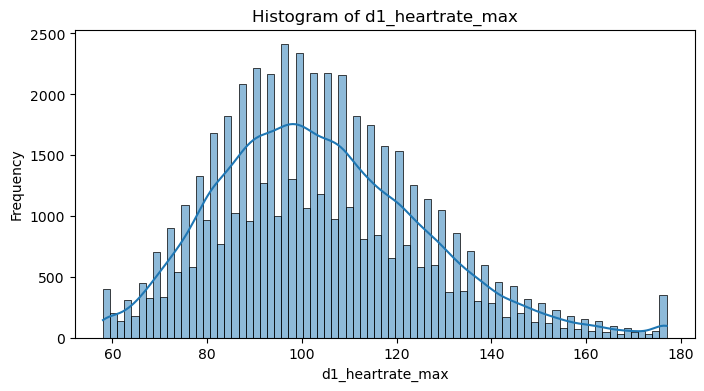

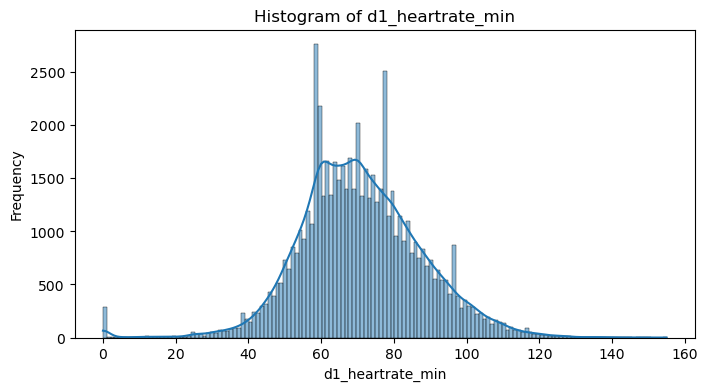

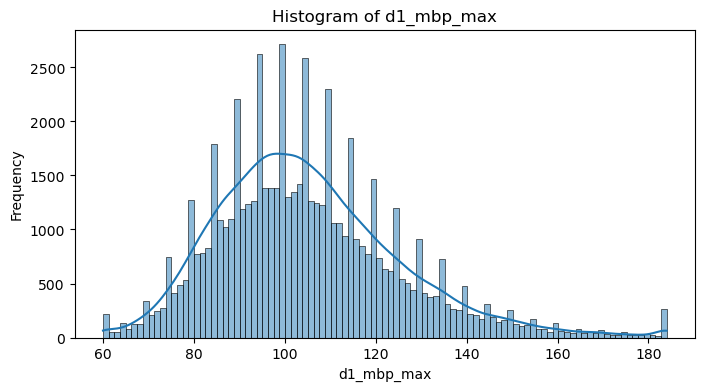

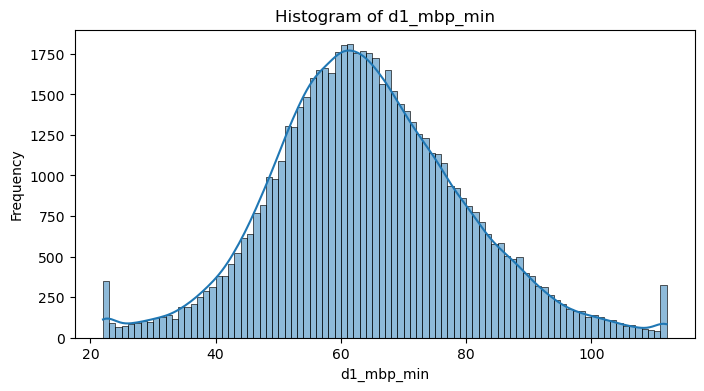

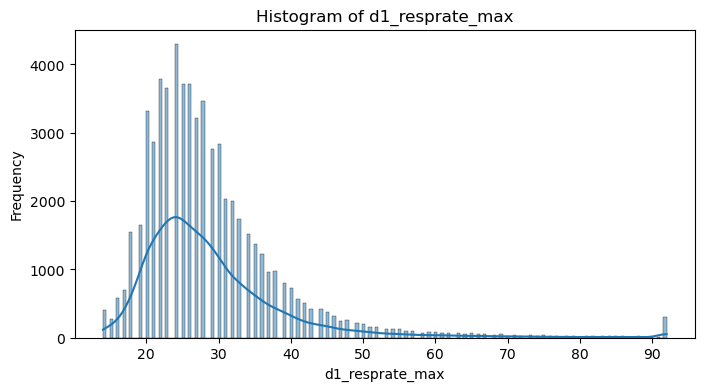

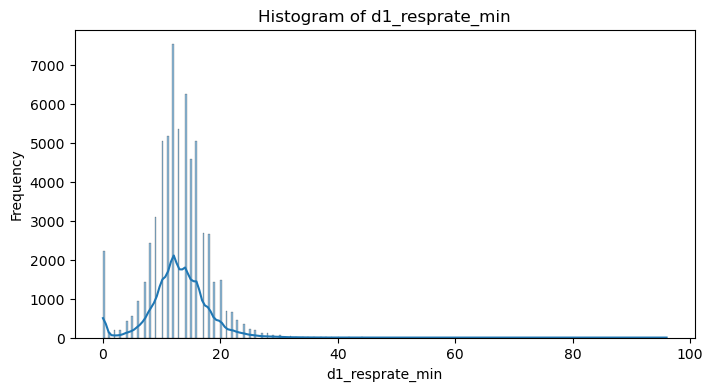

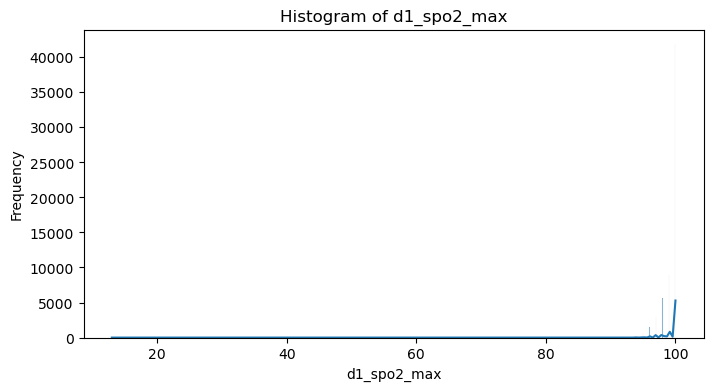

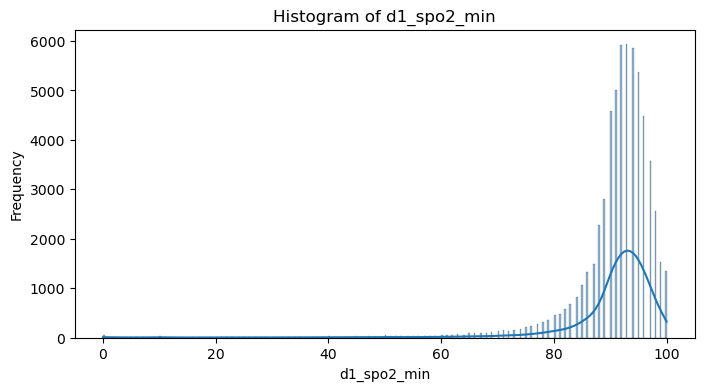

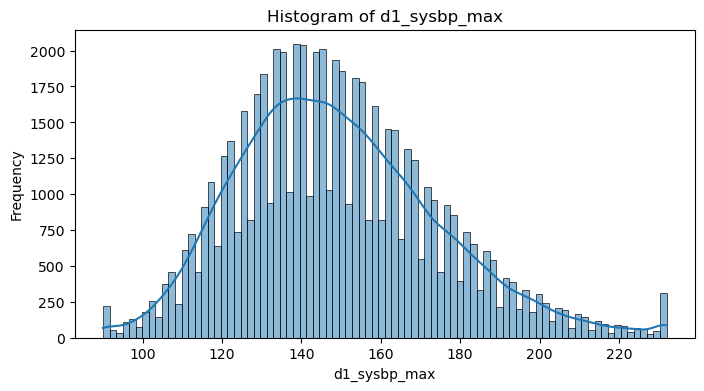

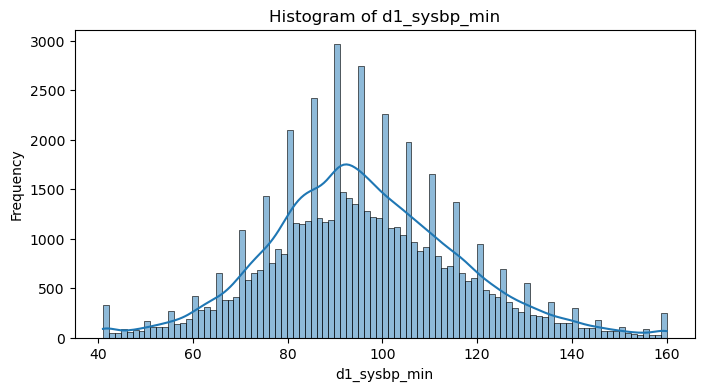

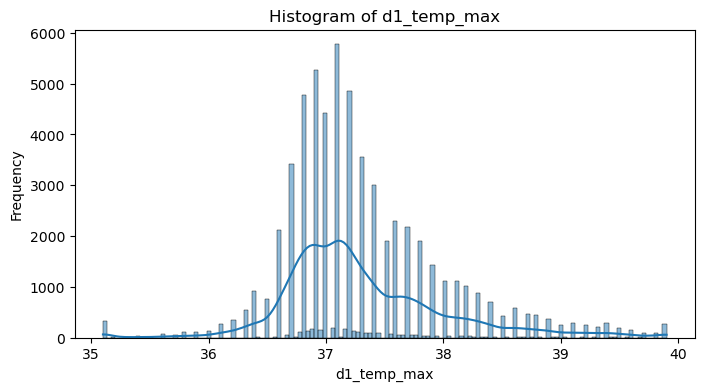

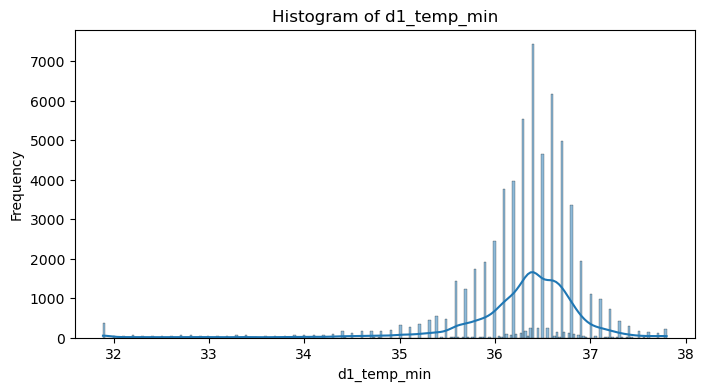

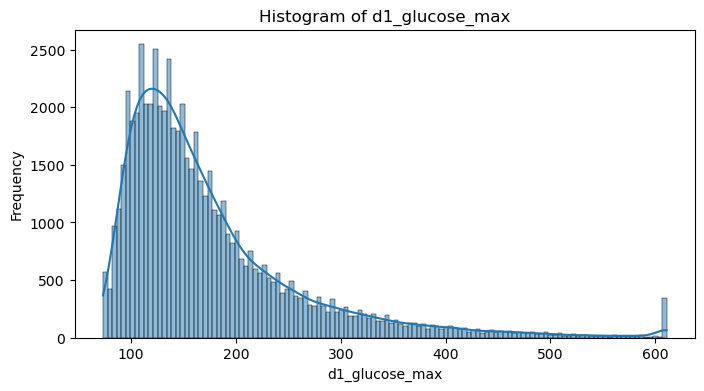

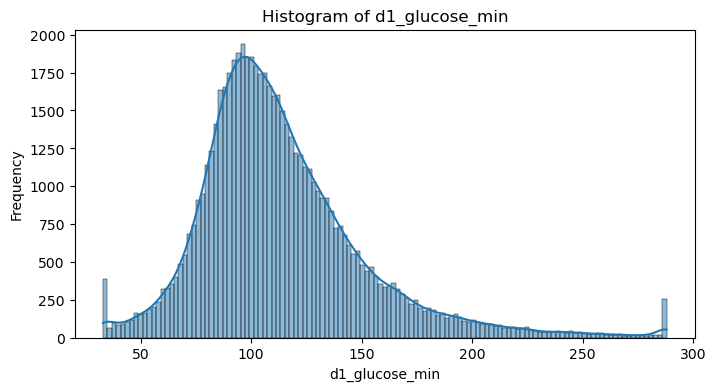

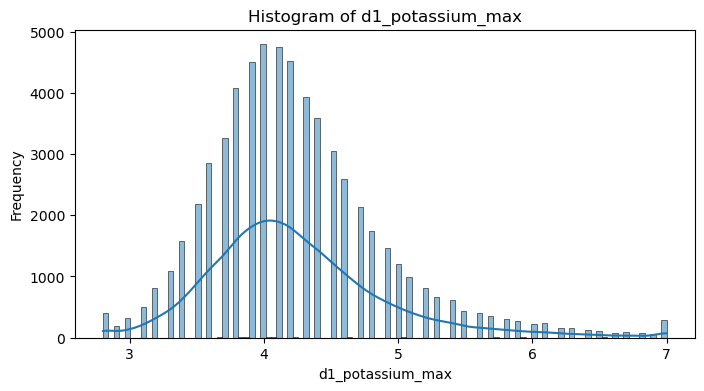

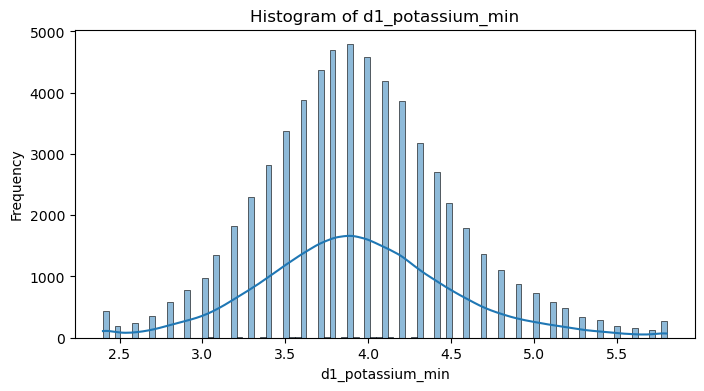

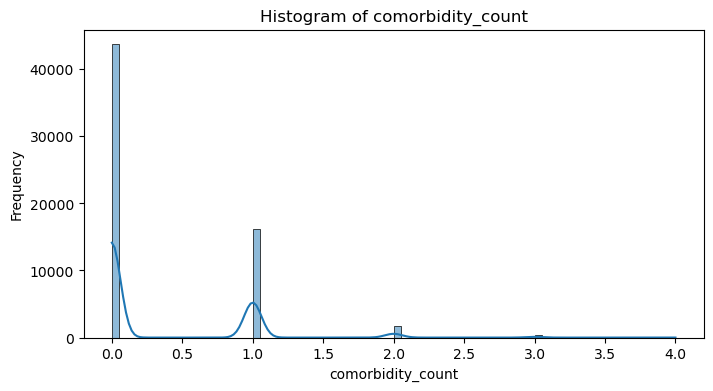

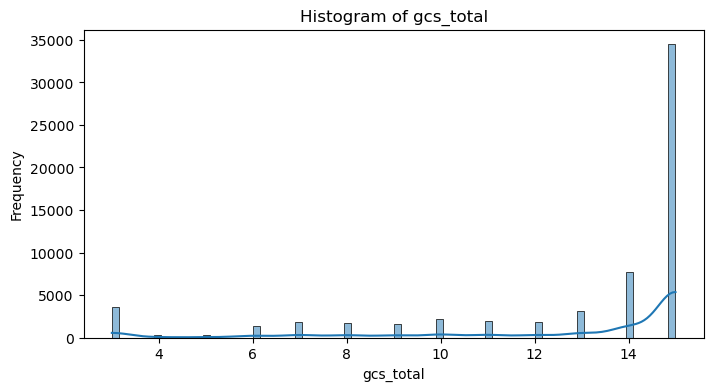

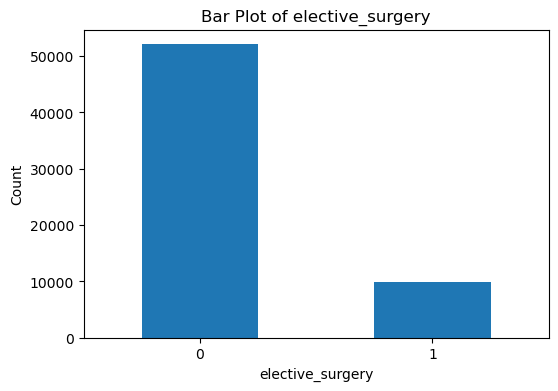

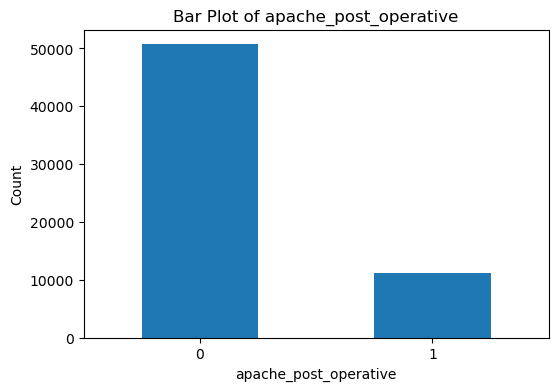

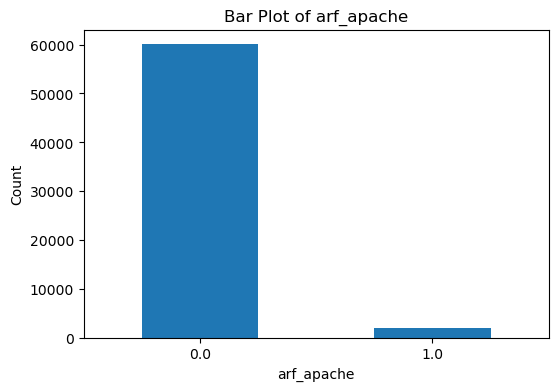

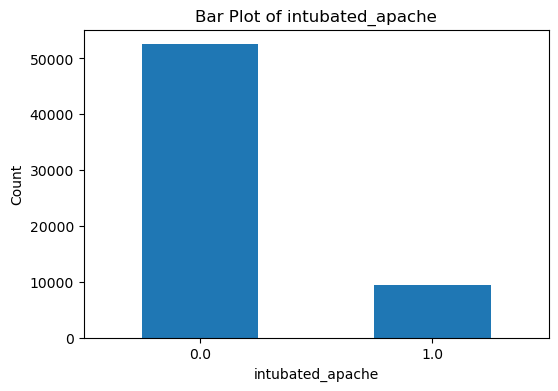

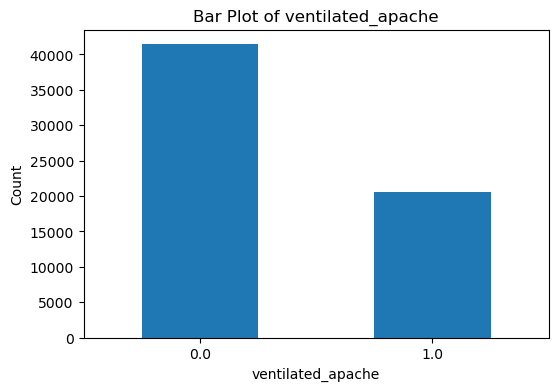

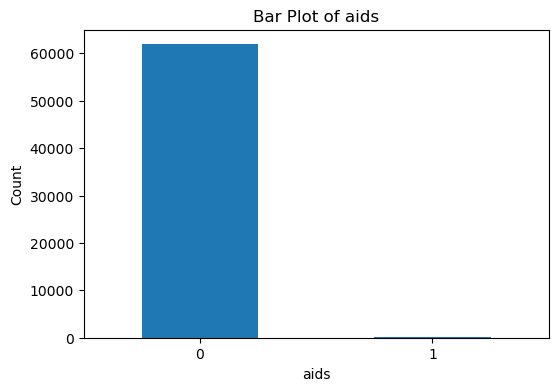

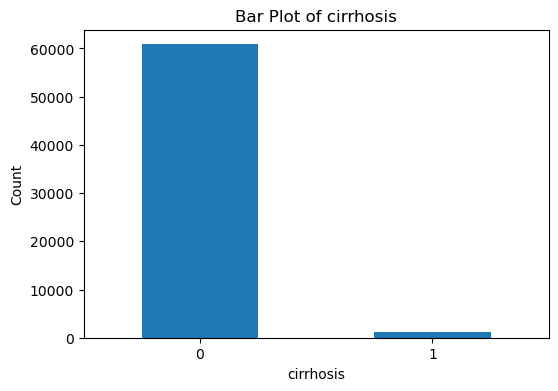

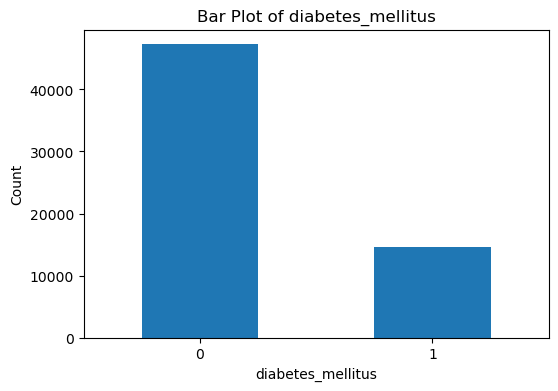

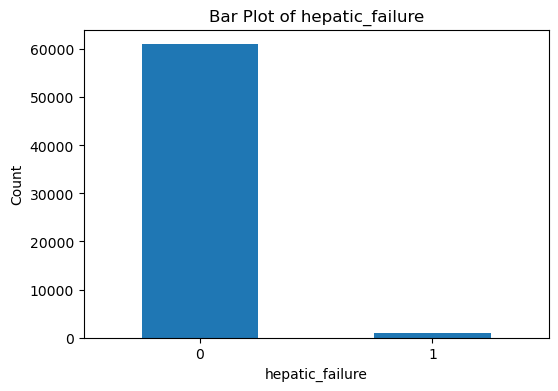

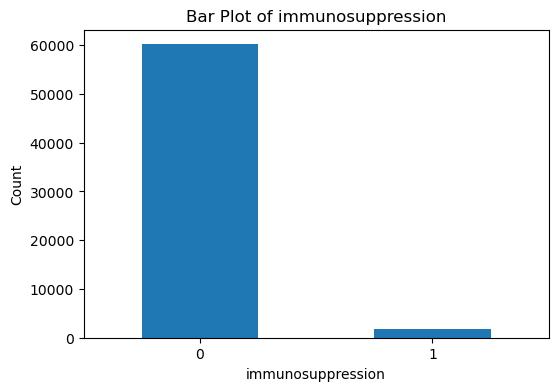

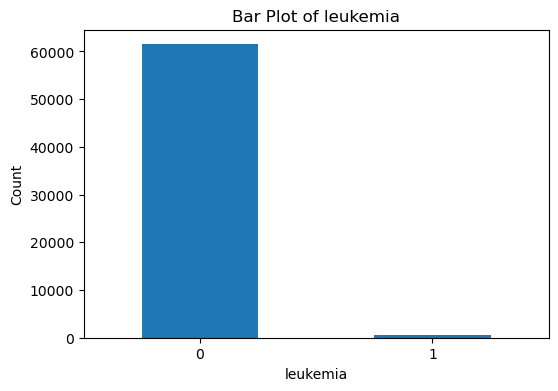

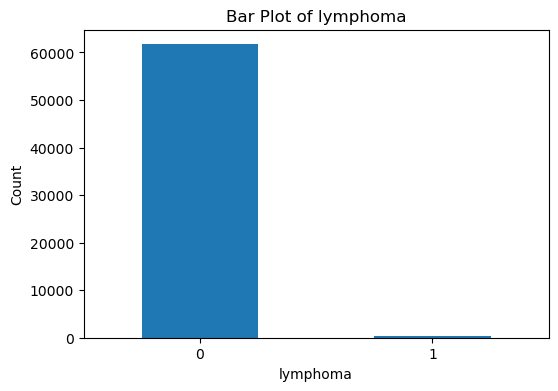

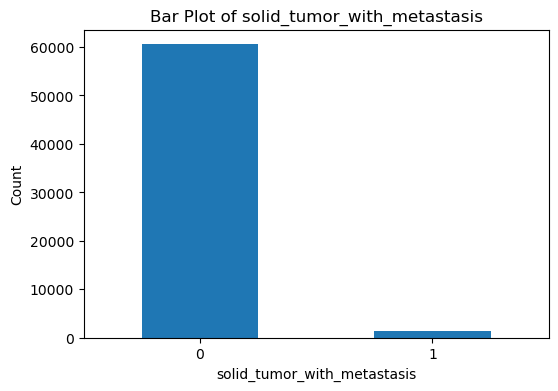

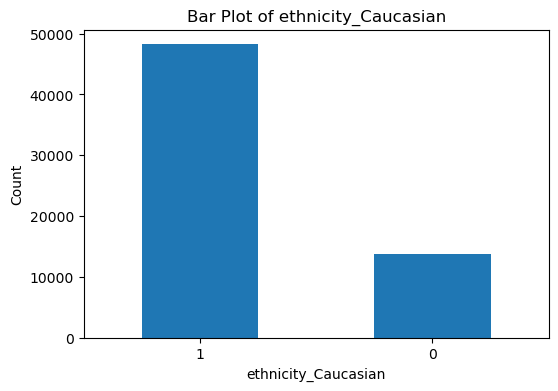

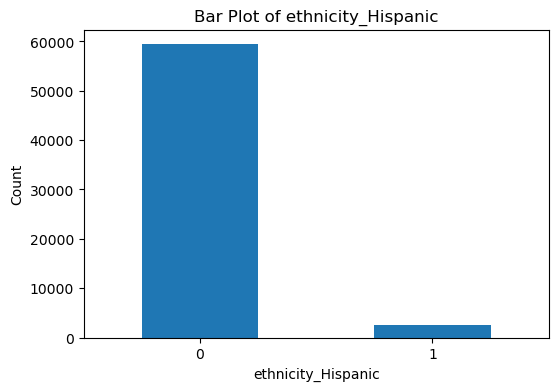

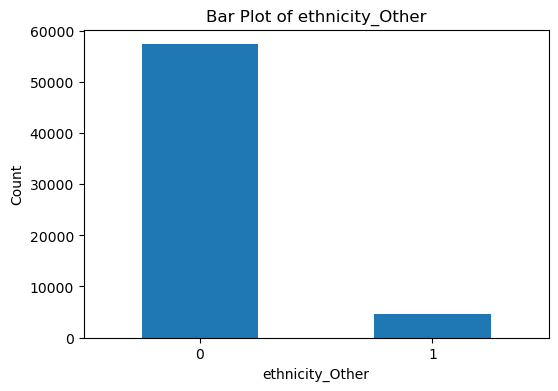

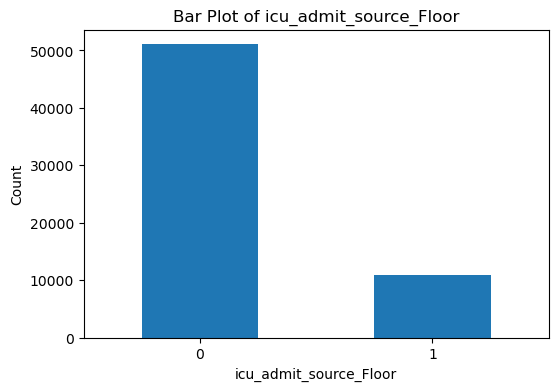

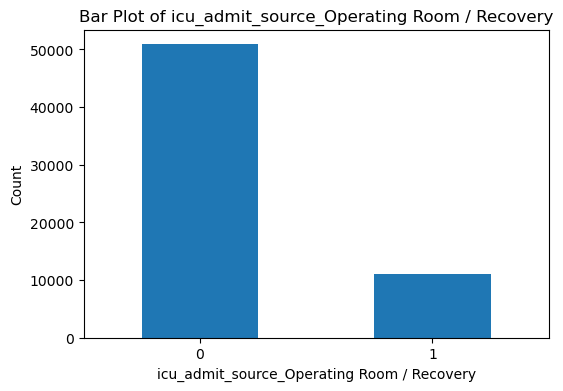

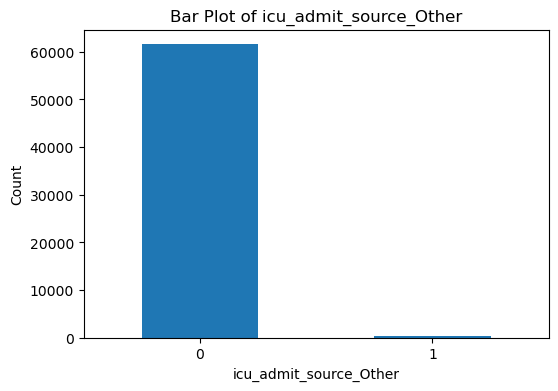

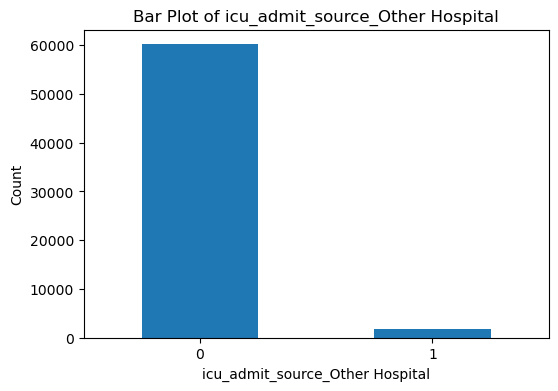

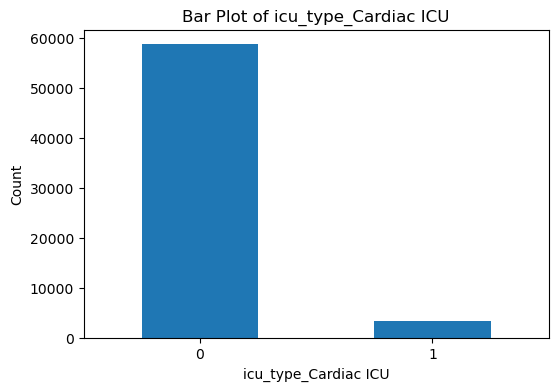

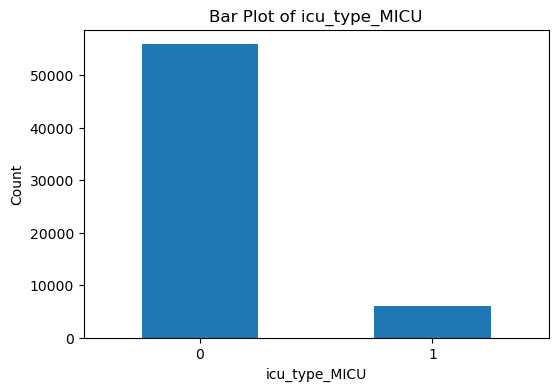

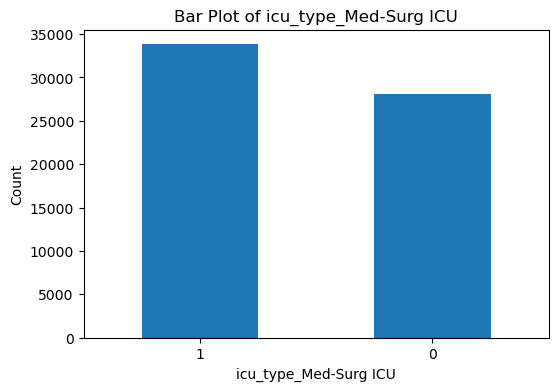

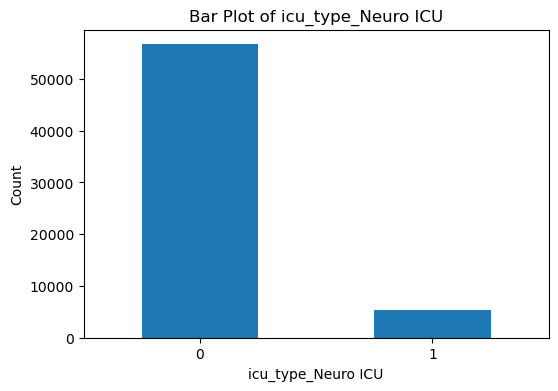

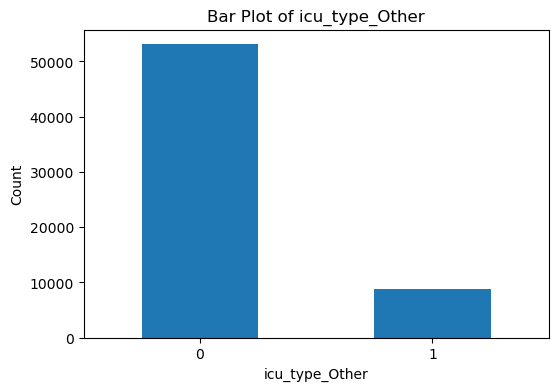

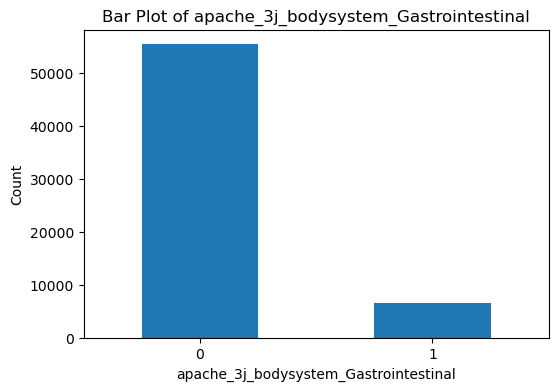

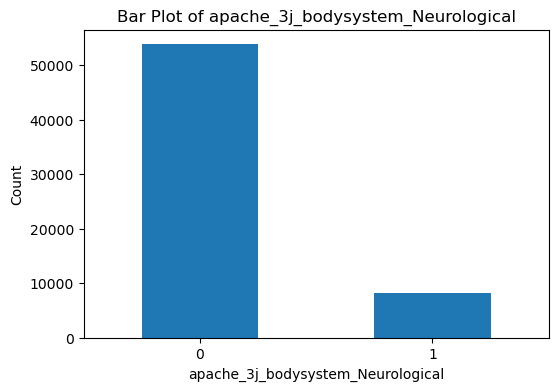

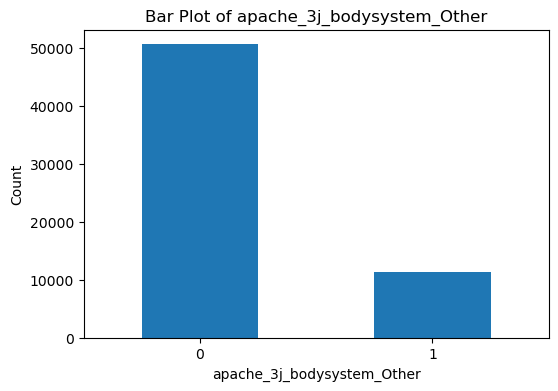

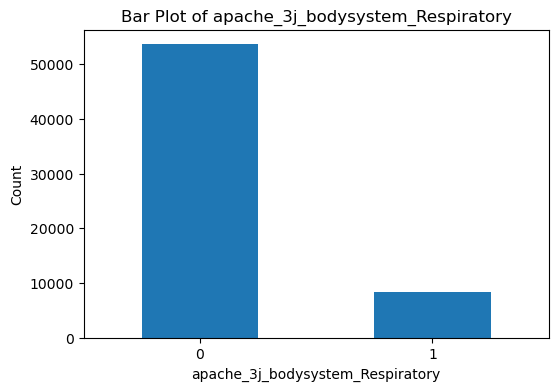

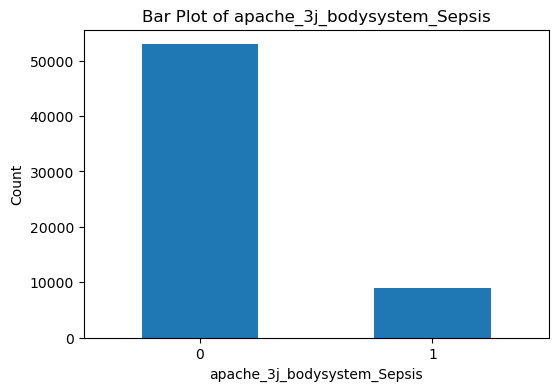

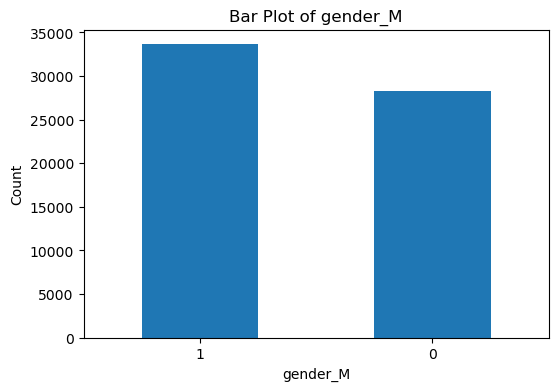

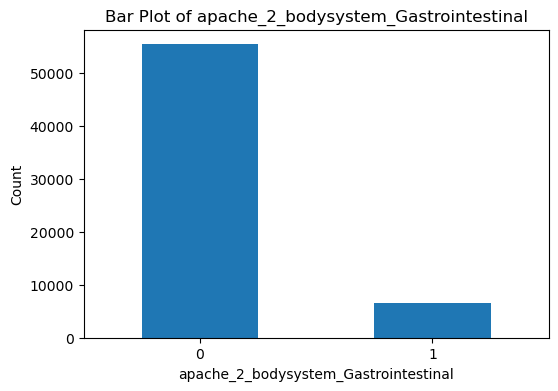

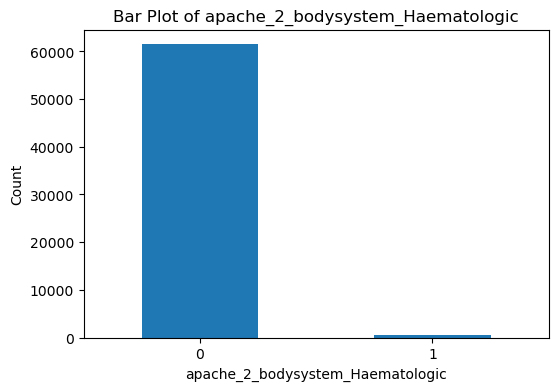

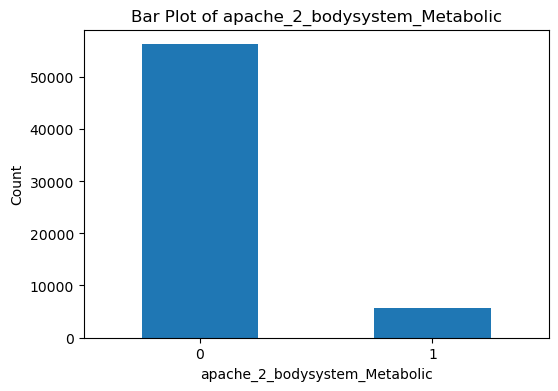

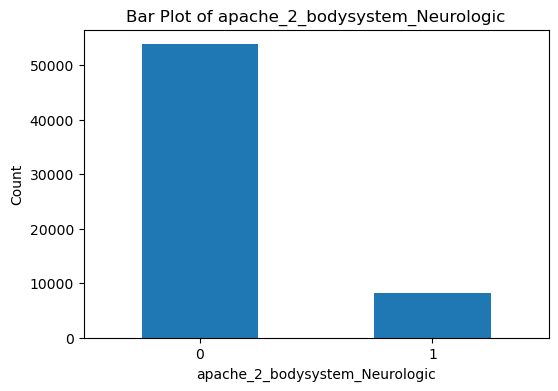

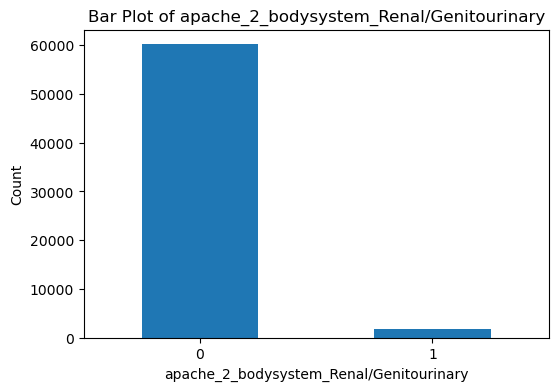

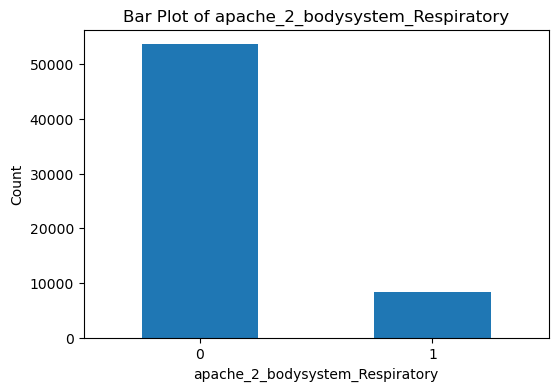

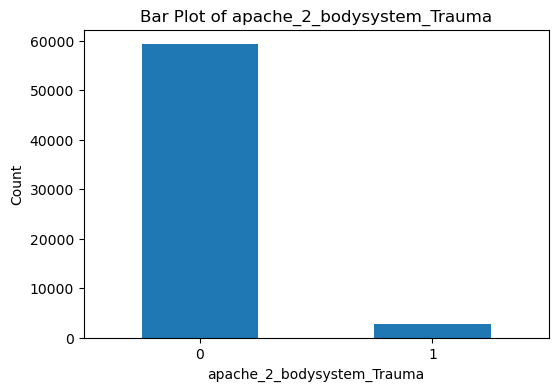

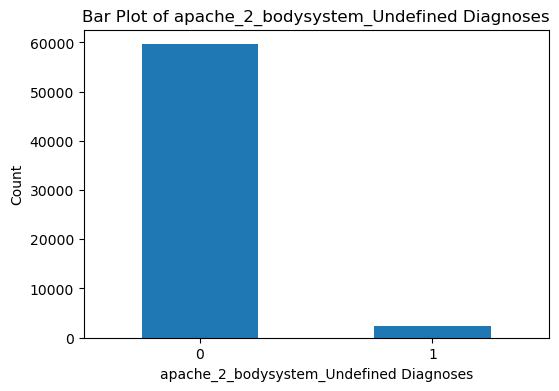

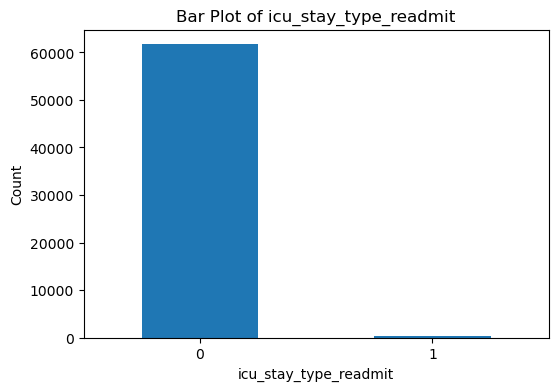

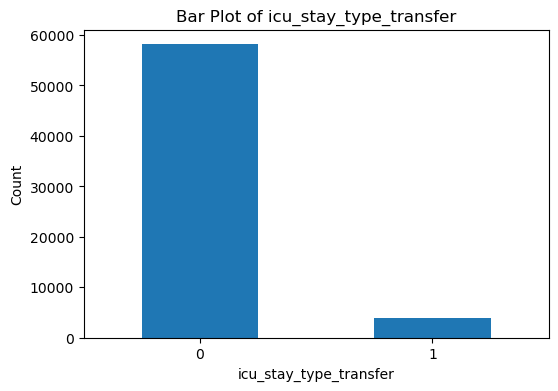

In [419]:
# For continuous numerical features, plot histograms
for col in continuous_numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# For binary features, plot bar plots
for col in binary_columns:
    plt.figure(figsize=(6, 4))
    data[col].value_counts().plot(kind='bar')
    plt.title(f'Bar Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()


Skewness of Continuous Numerical Features:
age                    -0.626256
bmi                     1.424387
height                 -0.106063
pre_icu_los_days        8.322550
weight                  1.074756
apache_2_diagnosis      0.587327
apache_3j_diagnosis     1.111808
gcs_eyes_apache        -1.579736
gcs_motor_apache       -2.632148
gcs_verbal_apache      -1.110699
heart_rate_apache      -0.311804
map_apache              0.689685
resprate_apache         0.226674
temp_apache            -0.877049
d1_diasbp_max           0.835660
d1_diasbp_min           0.090830
d1_heartrate_max        0.551853
d1_heartrate_min       -0.036123
d1_mbp_max              0.804259
d1_mbp_min              0.224271
d1_resprate_max         2.521421
d1_resprate_min         0.125245
d1_spo2_max           -12.668732
d1_spo2_min            -4.741901
d1_sysbp_max            0.534414
d1_sysbp_min            0.244479
d1_temp_max             0.920935
d1_temp_min            -2.853369
d1_glucose_max          2.033515

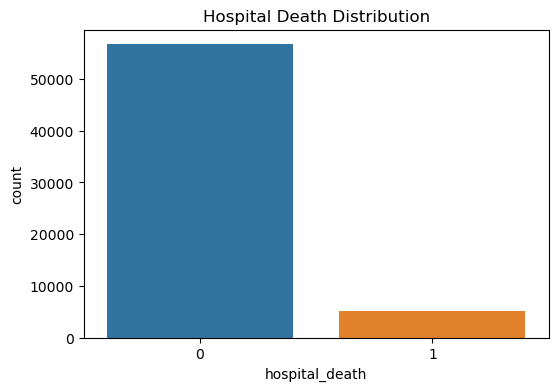

0    56741
1     5214
Name: hospital_death, dtype: int64

Percentage Distribution:
0    91.584214
1     8.415786
Name: hospital_death, dtype: float64


In [420]:
# Skewness of continuous numerical features
from scipy.stats import skew

skewness = data[continuous_numerical_features].apply(lambda x: skew(x.dropna()))
print("\nSkewness of Continuous Numerical Features:")
print(skewness)

# Plot distribution of target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='hospital_death', data=data)
plt.title('Hospital Death Distribution')
plt.show()
print(data['hospital_death'].value_counts())
print("\nPercentage Distribution:")
print(data['hospital_death'].value_counts(normalize=True) * 100)


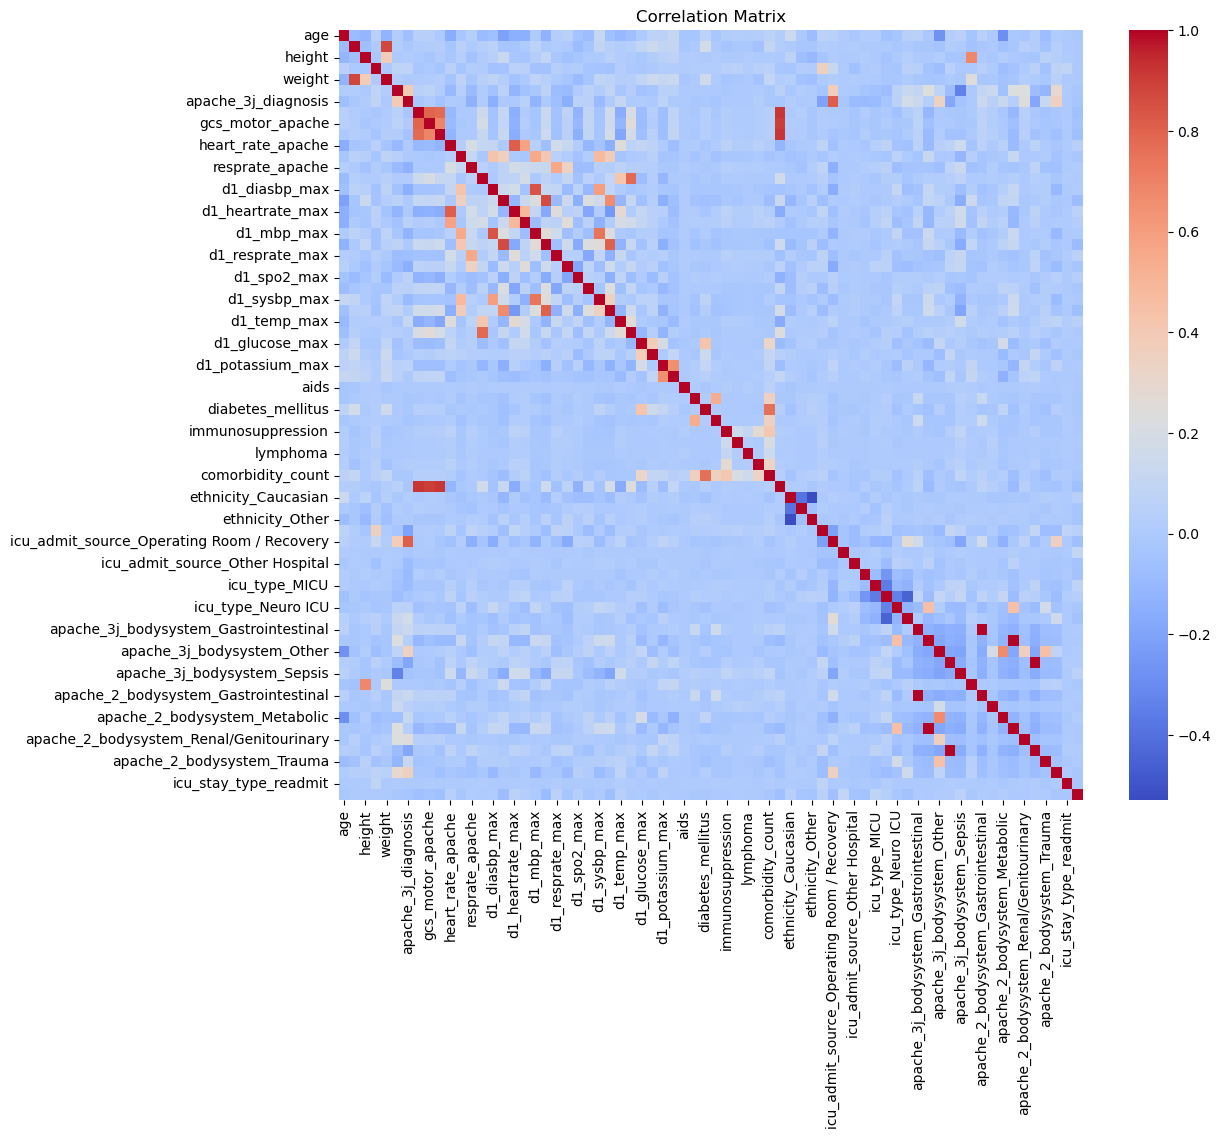

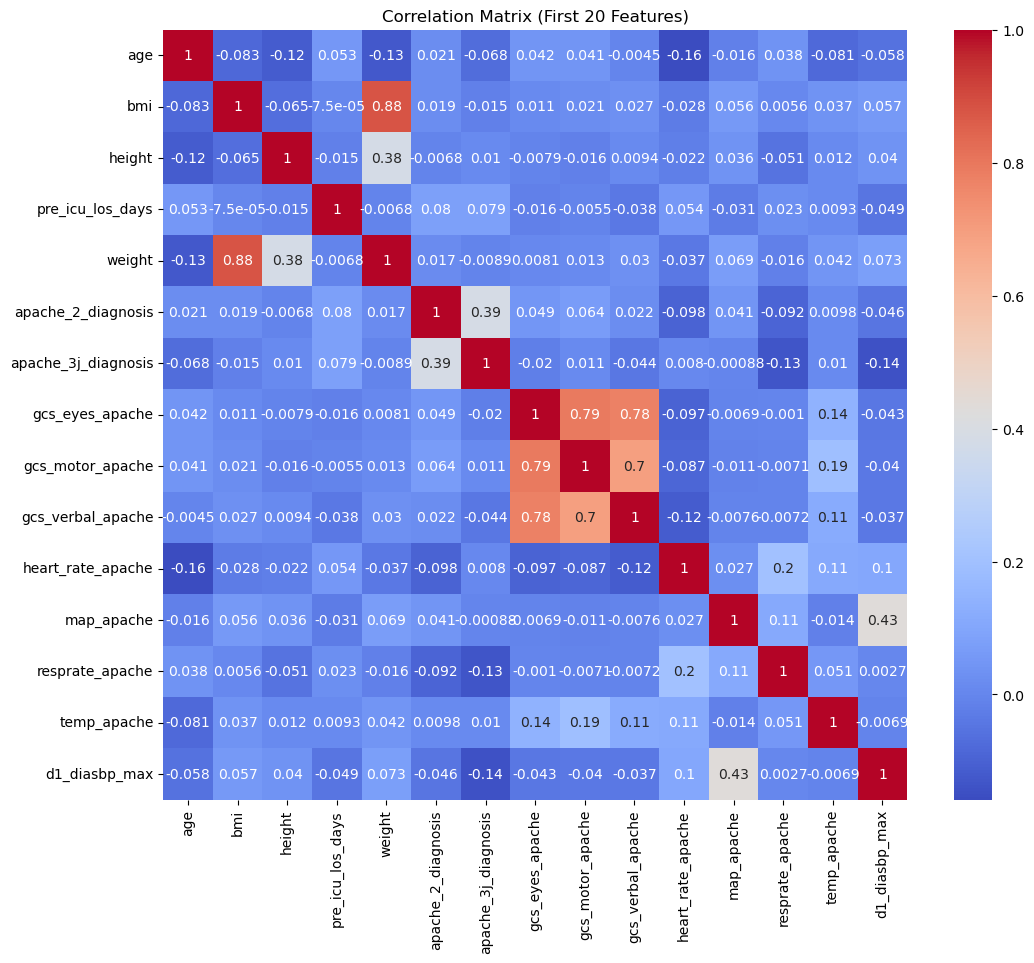

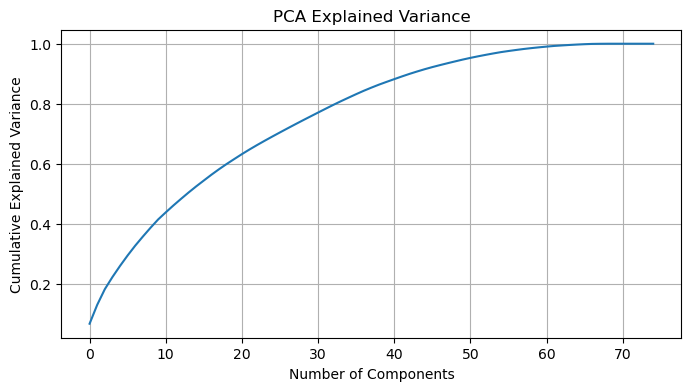

In [421]:
# Multicollinearity Analysis

# Prepare the features for correlation analysis (exclude the target variable)
X = data.drop('hospital_death', axis=1)

# Correlation matrix
plt.figure(figsize=(12, 10))
corr_matrix = X.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Select only the first 20 features for the correlation matrix
subset_corr_matrix = X.iloc[:, :20].corr()

# Plot the correlation matrix for the selected subset
plt.figure(figsize=(12, 10))
sns.heatmap(subset_corr_matrix, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix (First 20 Features)')
plt.show()

# PCA for multicollinearity

# Standardize the data before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
pca.fit(X_scaled)

# Plot cumulative explained variance ratio
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

In [422]:
# what to do with missing values
# problem if missing data is not random, then data will be skewed 

# keep correlated varibales? 

# i need to scale for almost anything not tree? (numeric values) 

# use PCA to only choose a subset of the blood pressure features (look at scree plot) 

# are there any models where I should not use SMOTE?
# if the truth becomes 50 - 50
# try without smote first 
# think about where the threshold should be 

# create an invasive variable if data is diff
# deal with all this blood stuff

# captum shap values
# LIME is outdated 
# benchmark against existing scores

# vif is only for linear!!

In [423]:
for col in data.columns:
    print(col)

age
bmi
elective_surgery
height
pre_icu_los_days
weight
apache_2_diagnosis
apache_3j_diagnosis
apache_post_operative
arf_apache
gcs_eyes_apache
gcs_motor_apache
gcs_verbal_apache
heart_rate_apache
intubated_apache
map_apache
resprate_apache
temp_apache
ventilated_apache
d1_diasbp_max
d1_diasbp_min
d1_heartrate_max
d1_heartrate_min
d1_mbp_max
d1_mbp_min
d1_resprate_max
d1_resprate_min
d1_spo2_max
d1_spo2_min
d1_sysbp_max
d1_sysbp_min
d1_temp_max
d1_temp_min
d1_glucose_max
d1_glucose_min
d1_potassium_max
d1_potassium_min
aids
cirrhosis
diabetes_mellitus
hepatic_failure
immunosuppression
leukemia
lymphoma
solid_tumor_with_metastasis
hospital_death
comorbidity_count
gcs_total
ethnicity_Caucasian
ethnicity_Hispanic
ethnicity_Other
icu_admit_source_Floor
icu_admit_source_Operating Room / Recovery
icu_admit_source_Other
icu_admit_source_Other Hospital
icu_type_Cardiac ICU
icu_type_MICU
icu_type_Med-Surg ICU
icu_type_Neuro ICU
icu_type_Other
apache_3j_bodysystem_Gastrointestinal
apache_3j_body

In [424]:
categorical_columns = data.select_dtypes(include=['object']).columns

print("Categorical Columns in the Dataset:")
for col in categorical_columns:
    print(col)

Categorical Columns in the Dataset:


In [425]:
binary_categorical_columns = [col for col in data.columns if data[col].nunique() == 2 and sorted(data[col].unique()) == [0, 1]]

print("Binary Categorical Columns (0 and 1 values only):")
for col in binary_categorical_columns:
    print(col)

Binary Categorical Columns (0 and 1 values only):
elective_surgery
apache_post_operative
arf_apache
intubated_apache
ventilated_apache
aids
cirrhosis
diabetes_mellitus
hepatic_failure
immunosuppression
leukemia
lymphoma
solid_tumor_with_metastasis
hospital_death
ethnicity_Caucasian
ethnicity_Hispanic
ethnicity_Other
icu_admit_source_Floor
icu_admit_source_Operating Room / Recovery
icu_admit_source_Other
icu_admit_source_Other Hospital
icu_type_Cardiac ICU
icu_type_MICU
icu_type_Med-Surg ICU
icu_type_Neuro ICU
icu_type_Other
apache_3j_bodysystem_Gastrointestinal
apache_3j_bodysystem_Neurological
apache_3j_bodysystem_Other
apache_3j_bodysystem_Respiratory
apache_3j_bodysystem_Sepsis
gender_M
apache_2_bodysystem_Gastrointestinal
apache_2_bodysystem_Haematologic
apache_2_bodysystem_Metabolic
apache_2_bodysystem_Neurologic
apache_2_bodysystem_Renal/Genitourinary
apache_2_bodysystem_Respiratory
apache_2_bodysystem_Trauma
apache_2_bodysystem_Undefined Diagnoses
icu_stay_type_readmit
icu_stay_

## DATA SPLITTING AND IMPORTANCE TREE


=== Feature Importances ===
                                       Feature  Importance
0                                  d1_spo2_min    0.038406
1                                 d1_sysbp_min    0.036033
2                          apache_3j_diagnosis    0.034820
3                             d1_heartrate_min    0.034386
4                                  d1_temp_min    0.032470
5                                   d1_mbp_min    0.032136
6                                  temp_apache    0.031033
7                                   map_apache    0.030978
8                               d1_glucose_min    0.030915
9                             pre_icu_los_days    0.030840
10                                         age    0.030185
11                            d1_heartrate_max    0.029517
12                                 d1_temp_max    0.028716
13                               d1_diasbp_min    0.028314
14                           heart_rate_apache    0.028276
15                         

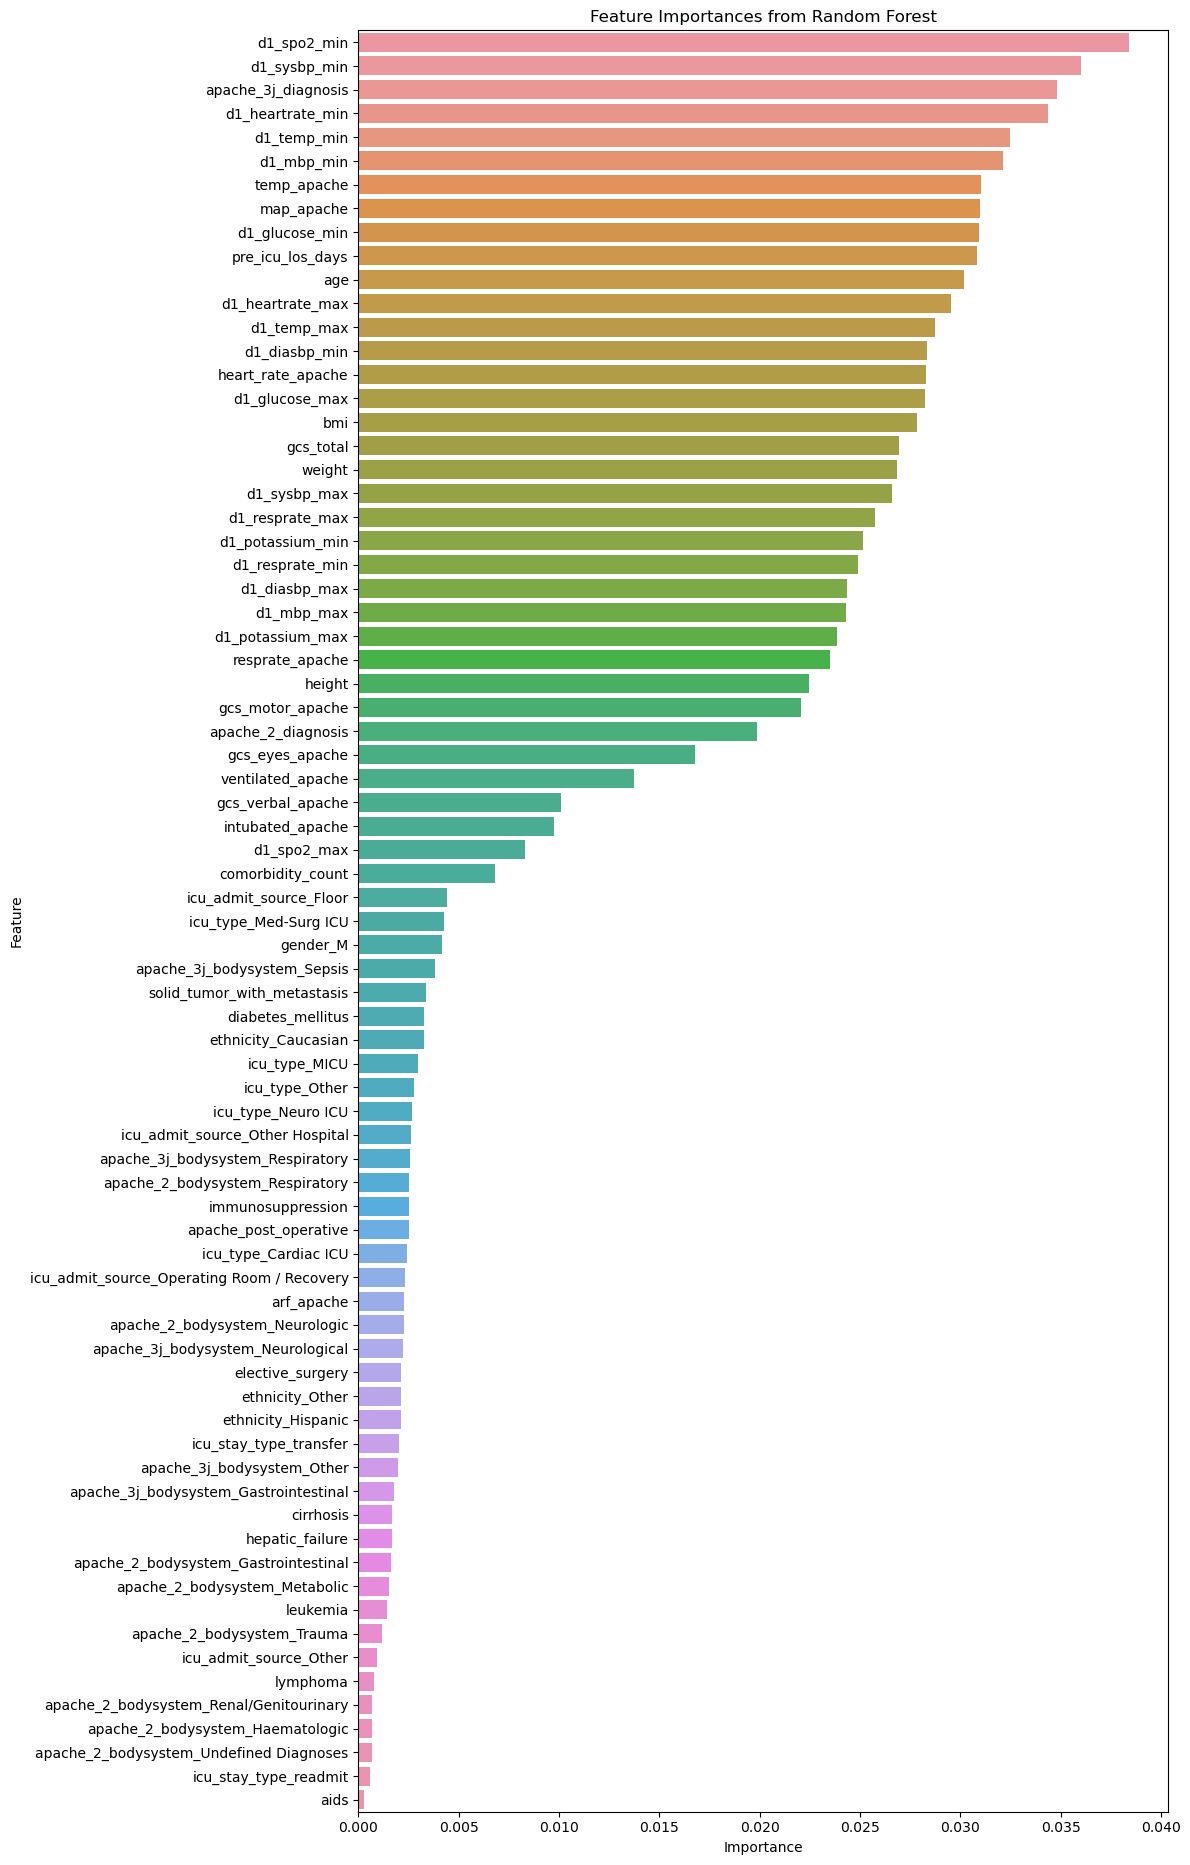


Datasets ready for modeling:
1. X_train_ns_ns, y_train_ns_ns (No Scaling, No SMOTE)
2. X_test_ns_ns, y_test_ns_ns
3. X_train_s_ns, y_train_s_ns (Scaling, No SMOTE)
4. X_test_s_ns, y_test_s_ns
5. X_train_ns_s, y_train_ns_s (No Scaling, SMOTENC)
6. X_test_ns_s, y_test_ns_s
7. X_train_s_s, y_train_s_s (Scaling, SMOTENC)
8. X_test_s_s, y_test_s_s


In [426]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTENC
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(18)
random.seed(18)

# Assuming 'data' is your preprocessed DataFrame with encoded categorical variables and no missing values

# Separate features and target variable
X = data.drop('hospital_death', axis=1)
y = data['hospital_death']

# --- 1. Split the Data into Training and Test Sets ---
# Use stratified sampling to maintain class distribution
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 2. Identify Numerical and Categorical Features ---
# Since encoding is already done, we can identify features based on data types

# Identify numerical features (excluding the target variable)
numerical_features = X_train_full.select_dtypes(include=[np.number]).columns.tolist()

# Identify categorical features
categorical_features = X_train_full.select_dtypes(exclude=[np.number]).columns.tolist()

# If any binary categorical features were encoded as numerical, add them to categorical_features
# Assuming you have a list of original binary categorical features
binary_categorical_features = [
    'elective_surgery', 'apache_post_operative', 'arf_apache', 'intubated_apache',
    'ventilated_apache', 'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
    'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis'
]

for col in binary_categorical_features:
    if col in numerical_features:
        numerical_features.remove(col)
        categorical_features.append(col)

# --- 3. Compute Feature Importances Using Random Forest ---

# Set pandas option to display all rows
pd.set_option('display.max_rows', None)

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train_full, y_train)

# Get feature importances
importances = rf_model.feature_importances_
feature_names = X_train_full.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Reset index for better display
feature_importance_df = feature_importance_df.reset_index(drop=True)

# Display the full list of features with their importance scores
print("\n=== Feature Importances ===")
print(feature_importance_df)

# Reset pandas option to default after printing
pd.reset_option('display.max_rows')

# Optional: Visualize Feature Importances
plt.figure(figsize=(12, len(feature_names) * 0.25))  # Adjust height based on number of features
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances from Random Forest')
plt.tight_layout()
plt.show()

# --- 4. Create Copies for Each Scenario ---

# a. No Scaling, No SMOTE
X_train_ns_ns = X_train_full.copy()
X_test_ns_ns = X_test_full.copy()
y_train_ns_ns = y_train.copy()
y_test_ns_ns = y_test.copy()

# b. Scaling, No SMOTE
X_train_s_ns = X_train_full.copy()
X_test_s_ns = X_test_full.copy()
y_train_s_ns = y_train.copy()
y_test_s_ns = y_test.copy()

# c. No Scaling, SMOTENC
X_train_ns_s = X_train_full.copy()
X_test_ns_s = X_test_full.copy()
y_train_ns_s = y_train.copy()
y_test_ns_s = y_test.copy()

# d. Scaling, SMOTENC
X_train_s_s = X_train_full.copy()
X_test_s_s = X_test_full.copy()
y_train_s_s = y_train.copy()
y_test_s_s = y_test.copy()

# --- 5. Apply Scaling Where Appropriate ---

# a. Scaling, No SMOTE
scaler_s_ns = StandardScaler()
X_train_s_ns[numerical_features] = scaler_s_ns.fit_transform(X_train_s_ns[numerical_features])
X_test_s_ns[numerical_features] = scaler_s_ns.transform(X_test_s_ns[numerical_features])

# b. Scaling, SMOTENC
scaler_s_s = StandardScaler()
X_train_s_s[numerical_features] = scaler_s_s.fit_transform(X_train_s_s[numerical_features])
X_test_s_s[numerical_features] = scaler_s_s.transform(X_test_s_s[numerical_features])

# --- 6. Apply SMOTE Where Appropriate ---

# Get categorical feature indices for SMOTENC
categorical_indices_ns_s = [X_train_ns_s.columns.get_loc(col) for col in categorical_features]
categorical_indices_s_s = [X_train_s_s.columns.get_loc(col) for col in categorical_features]

# a. No Scaling, SMOTENC
smotenc_ns_s = SMOTENC(categorical_features=categorical_indices_ns_s, random_state=42)
X_train_ns_s, y_train_ns_s = smotenc_ns_s.fit_resample(X_train_ns_s, y_train_ns_s)

# b. Scaling, SMOTENC
smotenc_s_s = SMOTENC(categorical_features=categorical_indices_s_s, random_state=42)
X_train_s_s, y_train_s_s = smotenc_s_s.fit_resample(X_train_s_s, y_train_s_s)

# --- 7. Datasets Ready for Modeling ---

print("\nDatasets ready for modeling:")
print("1. X_train_ns_ns, y_train_ns_ns (No Scaling, No SMOTE)")
print("2. X_test_ns_ns, y_test_ns_ns")
print("3. X_train_s_ns, y_train_s_ns (Scaling, No SMOTE)")
print("4. X_test_s_ns, y_test_s_ns")
print("5. X_train_ns_s, y_train_ns_s (No Scaling, SMOTENC)")
print("6. X_test_ns_s, y_test_ns_s")
print("7. X_train_s_s, y_train_s_s (Scaling, SMOTENC)")
print("8. X_test_s_s, y_test_s_s")


## Log reg 

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Hyperparameters: {'C': 1.0}

=== Logistic Regression Without SMOTENC (Lasso Regression with Hyperparameter Tuning) ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9303    0.9863    0.9574     11348
           1     0.5667    0.1956    0.2908      1043

    accuracy                         0.9197     12391
   macro avg     0.7485    0.5909    0.6241     12391
weighted avg     0.8997    0.9197    0.9013     12391

Confusion Matrix:
[[11192   156]
 [  839   204]]
ROC AUC Score: 0.8609


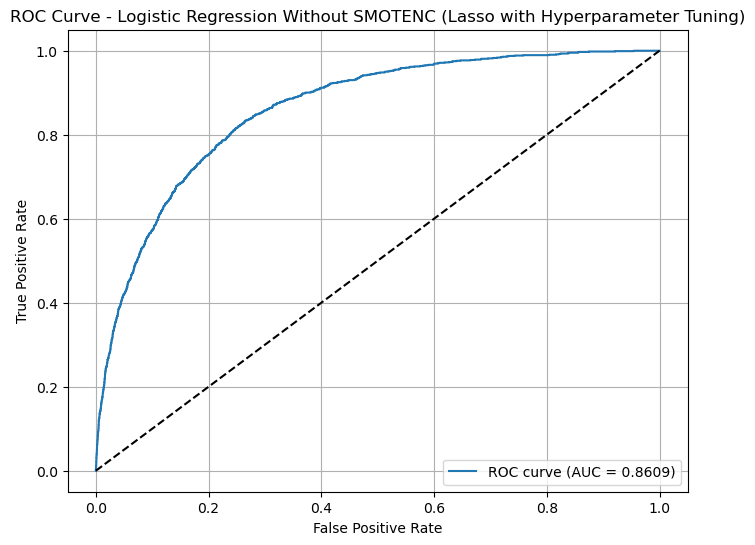

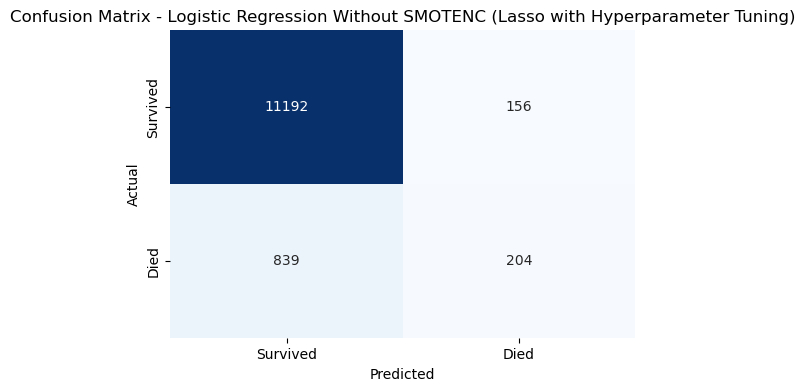

In [427]:
# --- Logistic Regression Without SMOTENC (Lasso Regression with Hyperparameter Tuning and Cross-Validation) ---

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Define the Parameter Grid with Fewer Values ---
param_grid = {
    'C': np.logspace(-2, 2, 5),  # Testing 5 values between 0.01 and 100
}

# --- 2. Set up Stratified K-Fold Cross-Validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- 3. Initialize the Logistic Regression Model with L1 Regularization ---
logreg = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    max_iter=1000,
    random_state=42
)

# --- 4. Set up GridSearchCV ---
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# --- 5. Train the Model ---
grid_search.fit(X_train_s_ns, y_train_s_ns)

# --- 6. Get the Best Model ---
best_logreg_ns = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")

# --- 7. Predict on the Test Set ---
y_pred_proba_ns = best_logreg_ns.predict_proba(X_test_s_ns)[:, 1]
y_pred_ns = best_logreg_ns.predict(X_test_s_ns)

# --- 8. Evaluate the Model ---
print("\n=== Logistic Regression Without SMOTENC (Lasso Regression with Hyperparameter Tuning) ===")
print("Classification Report:")
print(classification_report(y_test_s_ns, y_pred_ns, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_s_ns, y_pred_ns))
roc_auc_ns = roc_auc_score(y_test_s_ns, y_pred_proba_ns)
print(f"ROC AUC Score: {roc_auc_ns:.4f}")

# --- 9. Plot ROC Curve ---
fpr_ns, tpr_ns, thresholds_ns = roc_curve(y_test_s_ns, y_pred_proba_ns)
plt.figure(figsize=(8, 6))
plt.plot(fpr_ns, tpr_ns, label=f'ROC curve (AUC = {roc_auc_ns:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression Without SMOTENC (Lasso with Hyperparameter Tuning)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 10. Plot Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(
    y_test_s_ns,
    y_pred_ns,
    classes=['Survived', 'Died'],
    title='Confusion Matrix - Logistic Regression Without SMOTENC (Lasso with Hyperparameter Tuning)'
)


### LOG REG WITH SMOTE

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Hyperparameters: {'C': 100.0}

=== Logistic Regression With SMOTENC (Lasso Regression with Hyperparameter Tuning) ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9669    0.8296    0.8930     11348
           1     0.2716    0.6913    0.3899      1043

    accuracy                         0.8179     12391
   macro avg     0.6192    0.7604    0.6415     12391
weighted avg     0.9084    0.8179    0.8507     12391

Confusion Matrix:
[[9414 1934]
 [ 322  721]]
ROC AUC Score: 0.8420


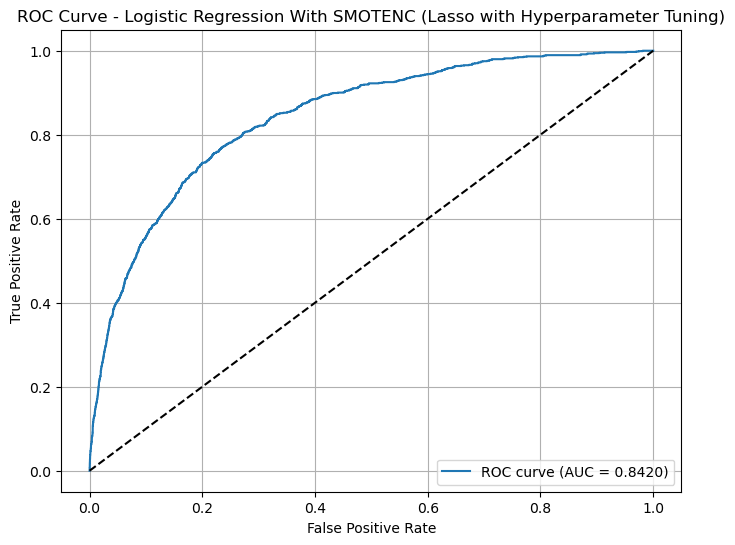

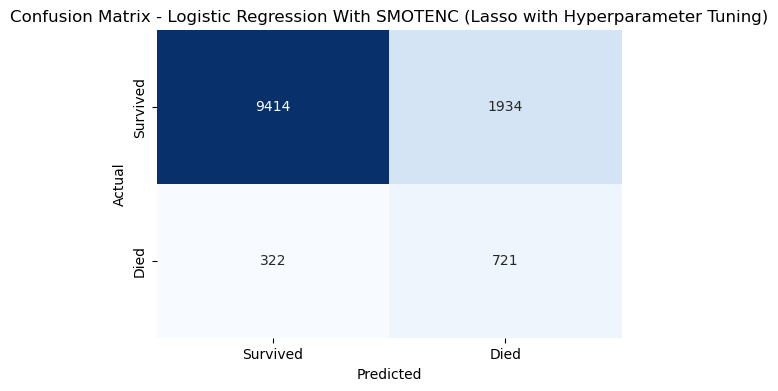

In [428]:
# --- Logistic Regression With SMOTENC (Lasso Regression with Hyperparameter Tuning and Cross-Validation) ---

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Define the Parameter Grid with Fewer Values ---
param_grid = {
    'C': np.logspace(-2, 2, 5),
}

# --- 2. Set up Stratified K-Fold Cross-Validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- 3. Initialize the Logistic Regression Model with L1 Regularization ---
logreg = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    max_iter=1000,
    random_state=42
)

# --- 4. Set up GridSearchCV ---
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# --- 5. Train the Model ---
grid_search.fit(X_train_s_s, y_train_s_s)

# --- 6. Get the Best Model ---
best_logreg_s = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")

# --- 7. Predict on the Test Set ---
y_pred_proba_s = best_logreg_s.predict_proba(X_test_s_s)[:, 1]
y_pred_s = best_logreg_s.predict(X_test_s_s)

# --- 8. Evaluate the Model ---
print("\n=== Logistic Regression With SMOTENC (Lasso Regression with Hyperparameter Tuning) ===")
print("Classification Report:")
print(classification_report(y_test_s_s, y_pred_s, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_s_s, y_pred_s))
roc_auc_s = roc_auc_score(y_test_s_s, y_pred_proba_s)
print(f"ROC AUC Score: {roc_auc_s:.4f}")

# --- 9. Plot ROC Curve ---
fpr_s, tpr_s, thresholds_s = roc_curve(y_test_s_s, y_pred_proba_s)
plt.figure(figsize=(8, 6))
plt.plot(fpr_s, tpr_s, label=f'ROC curve (AUC = {roc_auc_s:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression With SMOTENC (Lasso with Hyperparameter Tuning)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 10. Plot Confusion Matrix ---
plot_confusion_matrix(
    y_test_s_s,
    y_pred_s,
    classes=['Survived', 'Died'],
    title='Confusion Matrix - Logistic Regression With SMOTENC (Lasso with Hyperparameter Tuning)'
)



Threshold for desired recall of 90%: 0.20
Precision: 0.1558, Recall: 0.9003, F1-score: 0.2656

=== Logistic Regression With SMOTENC (Threshold: 0.20) (Lasso Regression) ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9837    0.5516    0.7068     11348
           1     0.1558    0.9003    0.2656      1043

    accuracy                         0.5809     12391
   macro avg     0.5697    0.7259    0.4862     12391
weighted avg     0.9140    0.5809    0.6697     12391

Confusion Matrix:
[[6259 5089]
 [ 104  939]]


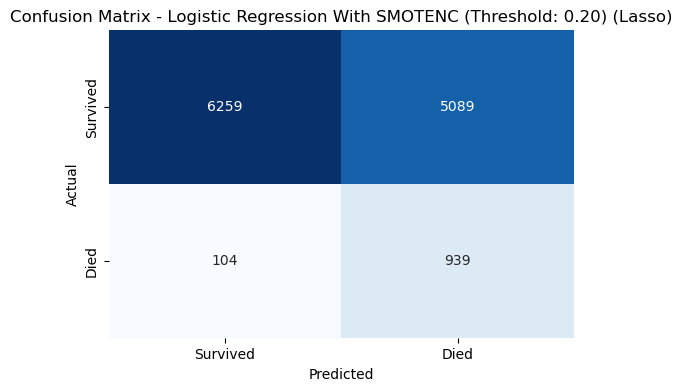

In [429]:
# --- Logistic Regression With SMOTENC (Adjusting Threshold for Desired Recall) (Lasso Regression) ---

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score
)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# --- Assuming model_lr_s is already trained and y_pred_proba_s is computed ---

# --- 1. Compute Precision-Recall Curve ---
precision_s, recall_s, thresholds_pr_s = precision_recall_curve(y_test_s_s, y_pred_proba_s)

# --- 2. Evaluate Metrics at Various Thresholds ---
def evaluate_thresholds(y_true, y_proba, thresholds):
    metrics_list = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        metrics_list.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })
    return metrics_list

# Define thresholds to evaluate
thresholds_to_evaluate = np.linspace(0, 1, 101)

# Evaluate metrics at each threshold
metrics_s = evaluate_thresholds(y_test_s_s, y_pred_proba_s, thresholds_to_evaluate)

# Convert to DataFrame for easy analysis
metrics_df_s = pd.DataFrame(metrics_s)

# --- 3. Choose Threshold Corresponding to Desired Recall ---
desired_recall = 0.90
# Find the threshold closest to the desired recall
metrics_df_s['recall_diff'] = metrics_df_s['recall'] - desired_recall
metrics_df_s['recall_diff'] = metrics_df_s['recall_diff'].apply(lambda x: x if x >= 0 else np.nan)
optimal_index = metrics_df_s['recall_diff'].idxmin()
if not np.isnan(optimal_index):
    optimal_threshold_s = metrics_df_s.loc[optimal_index, 'threshold']
    precision_at_desired_recall = metrics_df_s.loc[optimal_index, 'precision']
    recall_at_desired_recall = metrics_df_s.loc[optimal_index, 'recall']
    f1_at_desired_recall = metrics_df_s.loc[optimal_index, 'f1_score']
    print(f"\nThreshold for desired recall of {desired_recall*100:.0f}%: {optimal_threshold_s:.2f}")
    print(f"Precision: {precision_at_desired_recall:.4f}, Recall: {recall_at_desired_recall:.4f}, F1-score: {f1_at_desired_recall:.4f}")
else:
    print("\nDesired recall not achievable with the model.")
    optimal_threshold_s = 0.5  # Default threshold

# --- 4. Predict with the Desired Threshold ---
y_pred_optimal_s = (y_pred_proba_s >= optimal_threshold_s).astype(int)

# --- 5. Evaluate the Model with the Desired Threshold ---
print(f"\n=== Logistic Regression With SMOTENC (Threshold: {optimal_threshold_s:.2f}) (Lasso Regression) ===")
print("Classification Report:")
print(classification_report(y_test_s_s, y_pred_optimal_s, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_s_s, y_pred_optimal_s))

# --- 6. Plot Confusion Matrix ---
plot_confusion_matrix(
    y_test_s_s,
    y_pred_optimal_s,
    classes=['Survived', 'Died'],
    title=f'Confusion Matrix - Logistic Regression With SMOTENC (Threshold: {optimal_threshold_s:.2f}) (Lasso)'
)


### Logistic Regression Without SMOTENC Using class_weight

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Hyperparameters: {'C': 0.1}

=== Logistic Regression with class_weight='balanced' (Lasso Regression with Hyperparameter Tuning) ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9739    0.7868    0.8704     11348
           1     0.2495    0.7709    0.3769      1043

    accuracy                         0.7855     12391
   macro avg     0.6117    0.7788    0.6237     12391
weighted avg     0.9129    0.7855    0.8289     12391

Confusion Matrix:
[[8929 2419]
 [ 239  804]]
ROC AUC Score: 0.8622


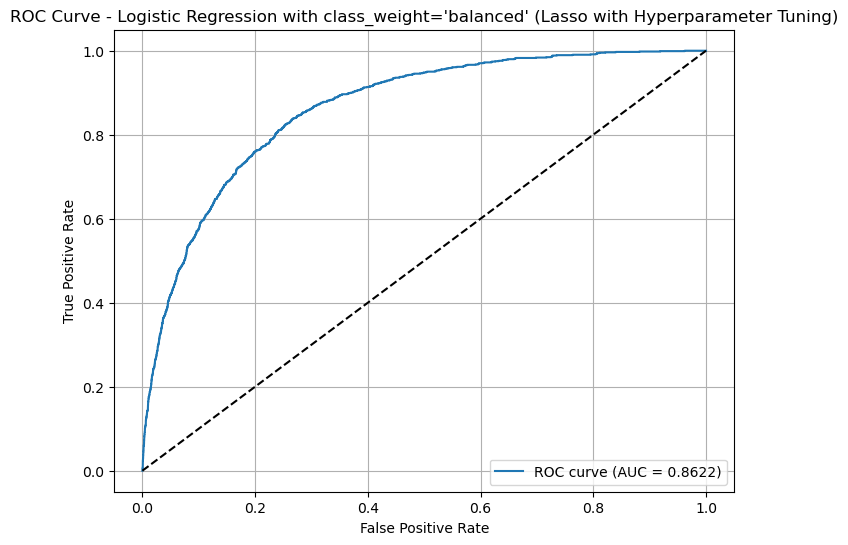

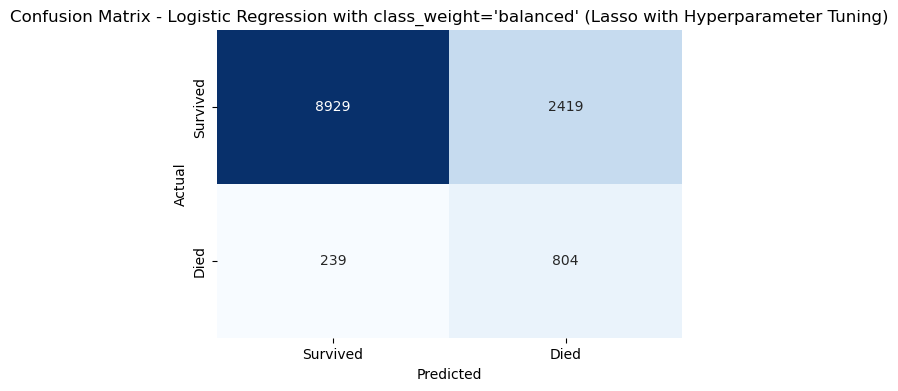

In [430]:
# --- Logistic Regression with class_weight='balanced' (Lasso Regression with Hyperparameter Tuning and Cross-Validation) ---

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Define the Parameter Grid with Fewer Values ---
param_grid = {
    'C': np.logspace(-2, 2, 5),
}

# --- 2. Set up Stratified K-Fold Cross-Validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- 3. Initialize the Logistic Regression Model with L1 Regularization and class_weight='balanced' ---
logreg = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

# --- 4. Set up GridSearchCV ---
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# --- 5. Train the Model ---
grid_search.fit(X_train_s_ns, y_train_s_ns)

# --- 6. Get the Best Model ---
best_logreg_balanced = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")

# --- 7. Predict on the Test Set ---
y_pred_proba_balanced = best_logreg_balanced.predict_proba(X_test_s_ns)[:, 1]
y_pred_balanced = best_logreg_balanced.predict(X_test_s_ns)

# --- 8. Evaluate the Model ---
print("\n=== Logistic Regression with class_weight='balanced' (Lasso Regression with Hyperparameter Tuning) ===")
print("Classification Report:")
print(classification_report(y_test_s_ns, y_pred_balanced, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_s_ns, y_pred_balanced))
roc_auc_balanced = roc_auc_score(y_test_s_ns, y_pred_proba_balanced)
print(f"ROC AUC Score: {roc_auc_balanced:.4f}")

# --- 9. Plot ROC Curve ---
fpr_balanced, tpr_balanced, thresholds_balanced = roc_curve(y_test_s_ns, y_pred_proba_balanced)
plt.figure(figsize=(8, 6))
plt.plot(fpr_balanced, tpr_balanced, label=f'ROC curve (AUC = {roc_auc_balanced:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression with class_weight=\'balanced\' (Lasso with Hyperparameter Tuning)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 10. Plot Confusion Matrix ---
plot_confusion_matrix(
    y_test_s_ns,
    y_pred_balanced,
    classes=['Survived', 'Died'],
    title='Confusion Matrix - Logistic Regression with class_weight=\'balanced\' (Lasso with Hyperparameter Tuning)'
)



Threshold for desired recall of 90%: 0.32
Precision: 0.1809, Recall: 0.9022, F1-score: 0.3014

=== Logistic Regression with class_weight='balanced' (Threshold: 0.32) (Lasso Regression) ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9858    0.6245    0.7646     11348
           1     0.1809    0.9022    0.3014      1043

    accuracy                         0.6479     12391
   macro avg     0.5834    0.7634    0.5330     12391
weighted avg     0.9181    0.6479    0.7256     12391

Confusion Matrix:
[[7087 4261]
 [ 102  941]]


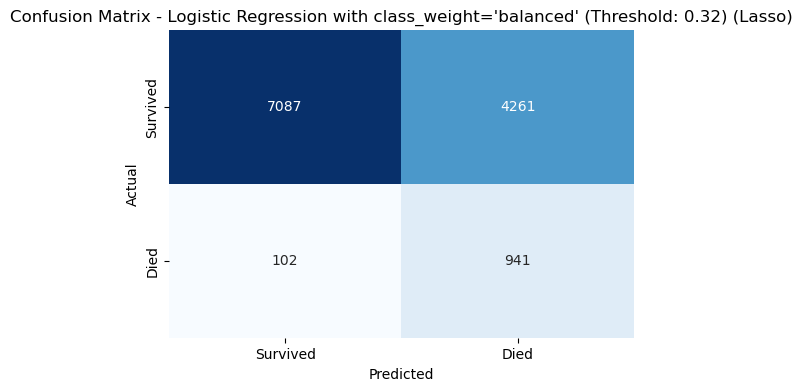

In [431]:
# --- Logistic Regression with class_weight='balanced' (Adjusting Threshold for Desired Recall) (Lasso Regression) ---

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score
)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# --- Assuming model_lr_balanced is already trained and y_pred_proba_balanced is computed ---

# --- 1. Compute Precision-Recall Curve ---
precision_balanced, recall_balanced, thresholds_pr_balanced = precision_recall_curve(y_test_s_ns, y_pred_proba_balanced)

# --- 2. Evaluate Metrics at Various Thresholds ---
metrics_balanced = evaluate_thresholds(y_test_s_ns, y_pred_proba_balanced, thresholds_to_evaluate)
metrics_df_balanced = pd.DataFrame(metrics_balanced)

# --- 3. Choose Threshold Corresponding to Desired Recall ---
desired_recall = 0.90
metrics_df_balanced['recall_diff'] = metrics_df_balanced['recall'] - desired_recall
metrics_df_balanced['recall_diff'] = metrics_df_balanced['recall_diff'].apply(lambda x: x if x >= 0 else np.nan)
optimal_index_balanced = metrics_df_balanced['recall_diff'].idxmin()
if not np.isnan(optimal_index_balanced):
    optimal_threshold_balanced = metrics_df_balanced.loc[optimal_index_balanced, 'threshold']
    precision_at_desired_recall_balanced = metrics_df_balanced.loc[optimal_index_balanced, 'precision']
    recall_at_desired_recall_balanced = metrics_df_balanced.loc[optimal_index_balanced, 'recall']
    f1_at_desired_recall_balanced = metrics_df_balanced.loc[optimal_index_balanced, 'f1_score']
    print(f"\nThreshold for desired recall of {desired_recall*100:.0f}%: {optimal_threshold_balanced:.2f}")
    print(f"Precision: {precision_at_desired_recall_balanced:.4f}, Recall: {recall_at_desired_recall_balanced:.4f}, F1-score: {f1_at_desired_recall_balanced:.4f}")
else:
    print("\nDesired recall not achievable with the model.")
    optimal_threshold_balanced = 0.5  # Default threshold

# --- 4. Predict with the Desired Threshold ---
y_pred_optimal_balanced = (y_pred_proba_balanced >= optimal_threshold_balanced).astype(int)

# --- 5. Evaluate the Model with the Desired Threshold ---
print(f"\n=== Logistic Regression with class_weight='balanced' (Threshold: {optimal_threshold_balanced:.2f}) (Lasso Regression) ===")
print("Classification Report:")
print(classification_report(y_test_s_ns, y_pred_optimal_balanced, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_s_ns, y_pred_optimal_balanced))

# --- 6. Plot Confusion Matrix ---
plot_confusion_matrix(
    y_test_s_ns,
    y_pred_optimal_balanced,
    classes=['Survived', 'Died'],
    title=f'Confusion Matrix - Logistic Regression with class_weight=\'balanced\' (Threshold: {optimal_threshold_balanced:.2f}) (Lasso)'
)


Interpretation:
Model 3 achieves the highest recall for deaths but at the cost of a high number of false positives and low precision.
Model 2 balances recall and precision for deaths better than Model 3 but still has many false positives.
Model 1 has high precision for deaths but very low recall, meaning it fails to identify most deaths.



### Random Forest


=== Random Forest Without Scaling and Without SMOTE ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9291    0.9928    0.9599     11348
           1     0.6906    0.1755    0.2798      1043

    accuracy                         0.9240     12391
   macro avg     0.8098    0.5841    0.6198     12391
weighted avg     0.9090    0.9240    0.9026     12391

Confusion Matrix:
[[11266    82]
 [  860   183]]
ROC AUC Score: 0.8548


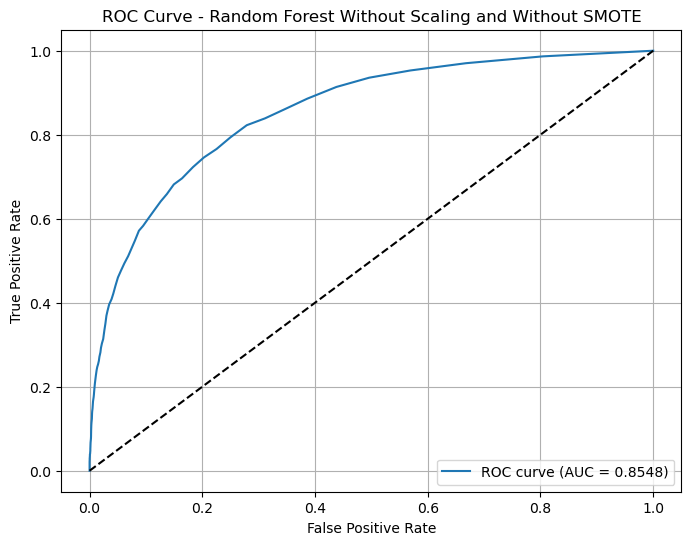

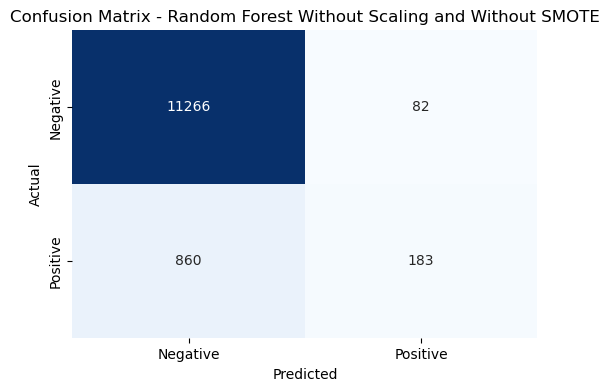

In [441]:
# --- Random Forest Without Scaling and Without SMOTE ---

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Initialize the Random Forest Model ---
rf_model1 = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

# --- 2. Train the Model ---
rf_model1.fit(X_train_ns_ns, y_train_ns_ns)

# --- 3. Predict on the Test Set ---
y_pred_proba_model1 = rf_model1.predict_proba(X_test_ns_ns)[:, 1]
y_pred_model1 = rf_model1.predict(X_test_ns_ns)

# --- 4. Evaluate the Model ---
print("\n=== Random Forest Without Scaling and Without SMOTE ===")
print("Classification Report:")
print(classification_report(y_test_ns_ns, y_pred_model1, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ns_ns, y_pred_model1))
roc_auc_model1 = roc_auc_score(y_test_ns_ns, y_pred_proba_model1)
print(f"ROC AUC Score: {roc_auc_model1:.4f}")

# --- 5. Plot ROC Curve ---
fpr_model1, tpr_model1, thresholds_model1 = roc_curve(y_test_ns_ns, y_pred_proba_model1)
plt.figure(figsize=(8, 6))
plt.plot(fpr_model1, tpr_model1, label=f'ROC curve (AUC = {roc_auc_model1:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Without Scaling and Without SMOTE')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 6. Plot Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(
    y_test_ns_ns,
    y_pred_model1,
    classes=['Negative', 'Positive'],
    title='Confusion Matrix - Random Forest Without Scaling and Without SMOTE'
)


Cross-Validated ROC AUC Scores: [0.99182896 0.99125153 0.99174739 0.99191312 0.99149296]
Mean ROC AUC Score: 0.9916

=== Random Forest Without Scaling and With SMOTE ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9386    0.9678    0.9530     11348
           1     0.4702    0.3106    0.3741      1043

    accuracy                         0.9125     12391
   macro avg     0.7044    0.6392    0.6636     12391
weighted avg     0.8991    0.9125    0.9042     12391

Confusion Matrix:
[[10983   365]
 [  719   324]]
ROC AUC Score: 0.8551


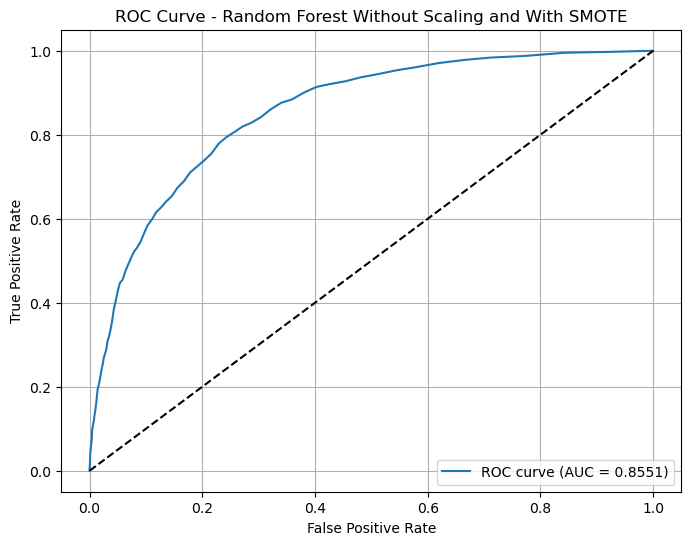

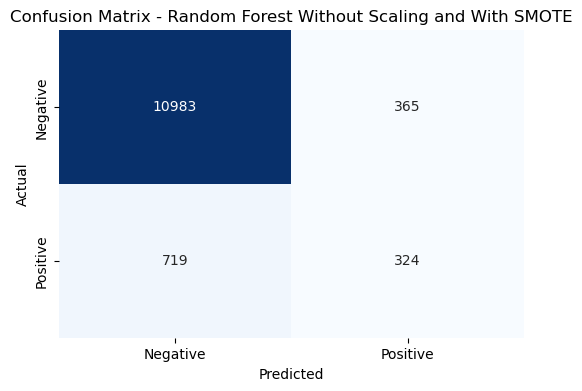

In [442]:
# --- Random Forest Without Scaling and With SMOTE with K-Fold Cross-Validation ---

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. Initialize the Random Forest Model ---
rf_model2 = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

# --- 2. Set up Stratified K-Fold Cross-Validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- 3. Perform Cross-Validation ---
cv_scores = cross_val_score(
    rf_model2,
    X_train_ns_s,
    y_train_ns_s,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
print(f"Cross-Validated ROC AUC Scores: {cv_scores}")
print(f"Mean ROC AUC Score: {np.mean(cv_scores):.4f}")

# --- 4. Train the Model on the Full Training Data ---
rf_model2.fit(X_train_ns_s, y_train_ns_s)

# --- 5. Predict on the Test Set ---
y_pred_proba_model2 = rf_model2.predict_proba(X_test_ns_s)[:, 1]
y_pred_model2 = rf_model2.predict(X_test_ns_s)

# --- 6. Evaluate the Model ---
print("\n=== Random Forest Without Scaling and With SMOTE ===")
print("Classification Report:")
print(classification_report(y_test_ns_s, y_pred_model2, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ns_s, y_pred_model2))
roc_auc_model2 = roc_auc_score(y_test_ns_s, y_pred_proba_model2)
print(f"ROC AUC Score: {roc_auc_model2:.4f}")

# --- 7. Plot ROC Curve ---
fpr_model2, tpr_model2, thresholds_model2 = roc_curve(y_test_ns_s, y_pred_proba_model2)
plt.figure(figsize=(8, 6))
plt.plot(fpr_model2, tpr_model2, label=f'ROC curve (AUC = {roc_auc_model2:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Without Scaling and With SMOTE')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 8. Plot Confusion Matrix ---
plot_confusion_matrix(
    y_test_ns_s,
    y_pred_model2,
    classes=['Negative', 'Positive'],
    title='Confusion Matrix - Random Forest Without Scaling and With SMOTE'
)


Cross-Validated ROC AUC Scores: [0.85436237 0.86048166 0.85930791 0.85762678 0.86152169]
Mean ROC AUC Score: 0.8587

=== Random Forest Without Scaling, Without SMOTE, With Class Weights ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9244    0.9958    0.9588     11348
           1     0.7126    0.1141    0.1967      1043

    accuracy                         0.9216     12391
   macro avg     0.8185    0.5549    0.5777     12391
weighted avg     0.9066    0.9216    0.8946     12391

Confusion Matrix:
[[11300    48]
 [  924   119]]
ROC AUC Score: 0.8601


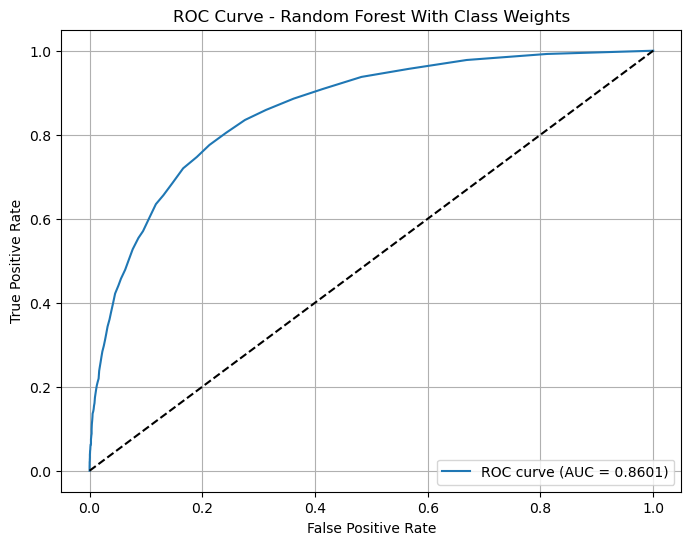

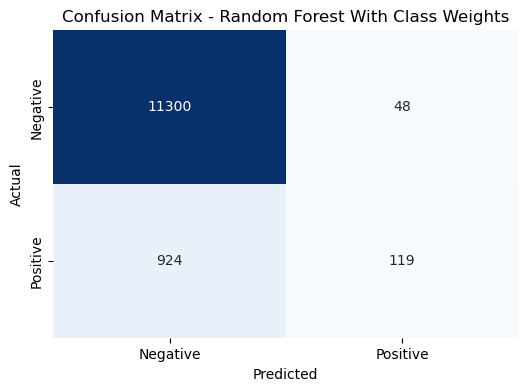

In [443]:
# --- Random Forest Without Scaling, Without SMOTE, With Class Weights and K-Fold Cross-Validation ---

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. Initialize the Random Forest Model with class_weight='balanced' ---
rf_model3 = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# --- 2. Set up Stratified K-Fold Cross-Validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- 3. Perform Cross-Validation ---
cv_scores = cross_val_score(
    rf_model3,
    X_train_ns_ns,
    y_train_ns_ns,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
print(f"Cross-Validated ROC AUC Scores: {cv_scores}")
print(f"Mean ROC AUC Score: {np.mean(cv_scores):.4f}")

# --- 4. Train the Model on the Full Training Data ---
rf_model3.fit(X_train_ns_ns, y_train_ns_ns)

# --- 5. Predict on the Test Set ---
y_pred_proba_model3 = rf_model3.predict_proba(X_test_ns_ns)[:, 1]
y_pred_model3 = rf_model3.predict(X_test_ns_ns)

# --- 6. Evaluate the Model ---
print("\n=== Random Forest Without Scaling, Without SMOTE, With Class Weights ===")
print("Classification Report:")
print(classification_report(y_test_ns_ns, y_pred_model3, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ns_ns, y_pred_model3))
roc_auc_model3 = roc_auc_score(y_test_ns_ns, y_pred_proba_model3)
print(f"ROC AUC Score: {roc_auc_model3:.4f}")

# --- 7. Plot ROC Curve ---
fpr_model3, tpr_model3, thresholds_model3 = roc_curve(y_test_ns_ns, y_pred_proba_model3)
plt.figure(figsize=(8, 6))
plt.plot(fpr_model3, tpr_model3, label=f'ROC curve (AUC = {roc_auc_model3:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest With Class Weights')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 8. Plot Confusion Matrix ---
plot_confusion_matrix(
    y_test_ns_ns,
    y_pred_model3,
    classes=['Negative', 'Positive'],
    title='Confusion Matrix - Random Forest With Class Weights'
)



Threshold for desired recall of 90%: 0.14
Precision: 0.1788, Recall: 0.9003, F1-score: 0.2983

=== Model with Adjusted Threshold (0.14) ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9854    0.6198    0.7610     11348
           1     0.1788    0.9003    0.2983      1043

    accuracy                         0.6435     12391
   macro avg     0.5821    0.7601    0.5296     12391
weighted avg     0.9175    0.6435    0.7221     12391

Confusion Matrix:
[[7034 4314]
 [ 104  939]]


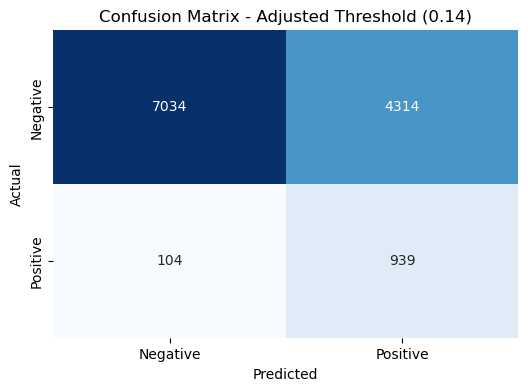

In [447]:
# --- Adjusting Threshold for Desired Recall ---

from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score
import numpy as np
import pandas as pd

# --- Variables to Change for Different Models ---
# Replace these variables with the corresponding variables from the model you want to adjust
y_test = y_test_ns_s
y_pred_proba = y_pred_proba_model2

# --- 1. Compute Precision-Recall Curve ---
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)

# --- 2. Evaluate Metrics at Various Thresholds ---
def evaluate_thresholds(y_true, y_proba, thresholds):
    metrics_list = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        precision_ = precision_score(y_true, y_pred, zero_division=0)
        recall_ = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        metrics_list.append({
            'threshold': threshold,
            'precision': precision_,
            'recall': recall_,
            'f1_score': f1
        })
    return metrics_list

# Define thresholds to evaluate
thresholds_to_evaluate = np.linspace(0, 1, 101)

# Evaluate metrics at each threshold
metrics = evaluate_thresholds(y_test, y_pred_proba, thresholds_to_evaluate)

# Convert to DataFrame for easy analysis
metrics_df = pd.DataFrame(metrics)

# --- 3. Choose Threshold Corresponding to Desired Recall ---
desired_recall = 0.90
metrics_df['recall_diff'] = metrics_df['recall'] - desired_recall
metrics_df['recall_diff'] = metrics_df['recall_diff'].apply(lambda x: x if x >= 0 else np.nan)
optimal_index = metrics_df['recall_diff'].idxmin()
if not np.isnan(optimal_index):
    optimal_threshold = metrics_df.loc[optimal_index, 'threshold']
    precision_at_desired_recall = metrics_df.loc[optimal_index, 'precision']
    recall_at_desired_recall = metrics_df.loc[optimal_index, 'recall']
    f1_at_desired_recall = metrics_df.loc[optimal_index, 'f1_score']
    print(f"\nThreshold for desired recall of {desired_recall*100:.0f}%: {optimal_threshold:.2f}")
    print(f"Precision: {precision_at_desired_recall:.4f}, Recall: {recall_at_desired_recall:.4f}, F1-score: {f1_at_desired_recall:.4f}")
else:
    print("\nDesired recall not achievable with the model.")
    optimal_threshold = 0.5  # Default threshold

# --- 4. Predict with the Desired Threshold ---
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# --- 5. Evaluate the Model with the Desired Threshold ---
print(f"\n=== Model with Adjusted Threshold ({optimal_threshold:.2f}) ===")
print("Classification Report:")
print(classification_report(y_test, y_pred_optimal, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_optimal))

# --- 6. Plot Confusion Matrix ---
plot_confusion_matrix(
    y_test,
    y_pred_optimal,
    classes=['Negative', 'Positive'],
    title=f'Confusion Matrix - Adjusted Threshold ({optimal_threshold:.2f})'
)
